#### Giacomo Falcone

<h1 style="text-align: center;"><strong>CROLLO DI FTX</strong></h1>

Filtro i dati che mi interessano nell'intervallo di tempo che mi interessa

### Tabella dei dati interessanti nei COMMENTI

| Dettaglio | Descrizione |
|--- |--- |
| **author** | Nome dell'utente che ha scritto il commento.|
| **body** | Il testo effettivo del commento.|
| **created_utc** | Timestamp UNIX che indica quando il commento è stato postato.|
| **score** | Punteggio del commento, che è la differenza tra upvote e downvote.|
| **controversiality** | Indica se un commento è controverso, basato sul numero di upvote e downvote che ha ricevuto.|
| **subreddit** | Nome del subreddit in cui è stato postato il commento.|
| **author_flair_text** | Può indicare il livello di competenza o il rango dell'utente all'interno della community, come "Platinum \| QC: CC 331".|
| **author_premium** | Indica se l'utente ha un abbonamento premium a Reddit.|
| **gilded** | Numero di volte che il commento è stato dorato (gold awards), indicativo dell'apprezzamento eccezionale da parte degli altri utenti.|
| **link_id** | Questo campo identifica il post a cui il commento è associato. Generalmente, inizia con "t3_" seguito da un identificativo unico.|
| **parent_id** | Se il commento è una risposta ad un altro commento, questo campo mostra l'ID del commento originale. Se inizia con "t1_", si riferisce a un commento; se inizia con "t3_", si riferisce a un post.|

In [5]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers
import pandas as pd

# Setup logging
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)

def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2 ** 31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2 ** 27, (2 ** 29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")
            for line in lines[:-1]:
                yield line, file_handle.tell()
            buffer = lines[-1]
        reader.close()

if __name__ == "__main__":
    file_path = "C:/Users/giaco/Desktop/POLIMI/ProgettoIngInf/CryptoCurrency_comments.zst" #sys.argv[1]
    file_size = os.stat(file_path).st_size
    file_lines = 0
    bad_lines = 0
    start_date = datetime.strptime("01/10/2022", "%d/%m/%Y")
    end_date = datetime.strptime("30/11/2022", "%d/%m/%Y")
    data = []  # Initialize an empty list to store data dictionaries

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            created = datetime.utcfromtimestamp(int(obj['created_utc']))
            if obj.get('body') not in ["[removed]", "[deleted]"] and start_date <= created <= end_date:
                # Append only the required fields to the list
                data.append({
                    'author': obj.get('author'),
                    'body': obj.get('body'),
                    'created_utc': created,
                    'score': obj.get('score'),
                    'controversiality': obj.get('controversiality'),
                    'subreddit': obj.get('subreddit'),
                    'author_flair_text': obj.get('author_flair_text'),
                    'author_premium': obj.get('author_premium'),
                    'gilded': obj.get('gilded'),
                    'link_id': obj.get('link_id'),
                    'parent_id': obj.get('parent_id')
                })
        except (KeyError, json.JSONDecodeError):
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(
                f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Convert the list of dictionaries to a DataFrame and save as JSON
    df = pd.DataFrame(data)
    df.to_json("filtered_ftx1.json", orient='records', lines=True)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


2016-10-15 13:32:25 : 100,000 : 0 : 27,394,675:1%
2016-10-15 13:32:25 : 100,000 : 0 : 27,394,675:1%
2016-10-15 13:32:25 : 100,000 : 0 : 27,394,675:1%
2017-07-13 09:27:10 : 200,000 : 0 : 27,394,675:1%
2017-07-13 09:27:10 : 200,000 : 0 : 27,394,675:1%
2017-07-13 09:27:10 : 200,000 : 0 : 27,394,675:1%
2017-08-31 15:21:32 : 300,000 : 0 : 48,366,675:1%
2017-08-31 15:21:32 : 300,000 : 0 : 48,366,675:1%
2017-08-31 15:21:32 : 300,000 : 0 : 48,366,675:1%
2017-09-30 11:14:13 : 400,000 : 0 : 48,366,675:1%
2017-09-30 11:14:13 : 400,000 : 0 : 48,366,675:1%
2017-09-30 11:14:13 : 400,000 : 0 : 48,366,675:1%
2017-10-29 10:49:36 : 500,000 : 0 : 69,338,675:2%
2017-10-29 10:49:36 : 500,000 : 0 : 69,338,675:2%
2017-10-29 10:49:36 : 500,000 : 0 : 69,338,675:2%
2017-11-19 14:53:49 : 600,000 : 0 : 69,338,675:2%
2017-11-19 14:53:49 : 600,000 : 0 : 69,338,675:2%
2017-11-19 14:53:49 : 600,000 : 0 : 69,338,675:2%
2017-12-04 03:28:38 : 700,000 : 0 : 89,917,450:2%
2017-12-04 03:28:38 : 700,000 : 0 : 89,917,450:2%


### Tabella dei dati interessanti nei POST

| **Nome**            | **Descrizione**                                                                                                    |
|---------------------|--------------------------------------------------------------------------------------------------------------------|
| **subreddit**       | Il nome del subreddit in cui il post è stato pubblicato, in questo caso "CryptoCurrency".                          |
| **score**           | Il punteggio netto del post, che è la differenza tra i voti positivi e negativi ricevuti. Il valore è 8.           |
| **selftext**        | Il testo principale del post. Contiene guide per minare criptovalute come Litecoin e Terracoin.                    |
| **permalink**       | Il link permanente al post su Reddit.                                                                              |
| **author**          | Il nome utente dell'autore del post, "CryptoJunky".                                                                |
| **num_comments**    | Il numero di commenti ricevuti dal post, 8.                                                                        |
| **created_utc**     | Il timestamp di creazione del post, espresso in secondi dal 1 gennaio 1970 (epoch), 1363107391.                    |
| **edited**          | Indica se il post è stato modificato dopo la pubblicazione, con il timestamp 1363129840.                           |
| **stickied**        | Indica se il post è stato fissato in cima al subreddit. È falso, quindi non è stato fissato.                       |
| **link_flair_text** | Il testo del flair associato al post. È null, indicando che non è stato impostato un flair specifico .             |
| **title**           | Il titolo del post, "Mining Guides".                                                                               |
| **distinguished**   | Indica se il post è stato fatto da un moderatore o un amministratore di Reddit. È null, quindi non è 
| **id**              | Indica l'id del post.                                                                                              |distintivo.   |
| **downs**           | Indica il numero di voti negativi ricevuti dal post.                                                               |
| **ups**             | Indica il numero di voti positivi ricevuti dal post.                                                               |

In [38]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers
import pandas as pd

# Setup del logging per visualizzare i messaggi di debug
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

# Funzione per leggere e decodificare i dati in modo sicuro
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)  # Legge un pezzo di dati dalla sorgente
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk  # Aggiunge il pezzo precedente se esiste
    try:
        return chunk.decode()  # Prova a decodificare i dati
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")  # Se il limite è superato, lancia un errore
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)  # Ripeti la lettura e decodifica

# Funzione per leggere linee da un file compresso .zst
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2 ** 31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2 ** 27, (2 ** 29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")  # Divide il chunk in linee
            for line in lines[:-1]:
                yield line, file_handle.tell()  # Genera ogni linea e la posizione nel file
            buffer = lines[-1]  # Salva l'ultima linea incompleta per il prossimo chunk
        reader.close()

if __name__ == "__main__":
    file_path = "C:/Users/giaco/Desktop/POLIMI/ProgettoIngInf/CryptoCurrency_submissions.zst"  # Percorso del file
    file_size = os.stat(file_path).st_size  # Ottieni la dimensione del file
    file_lines = 0
    bad_lines = 0
    start_date = datetime.strptime("01/10/2022", "%d/%m/%Y")  # Data di inizio per il filtro
    end_date = datetime.strptime("30/11/2022", "%d/%m/%Y")  # Data di fine per il filtro
    data = []  # Inizializza una lista vuota per memorizzare i dati

    # Legge il file linea per linea
    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Decodifica la linea JSON
            created = datetime.utcfromtimestamp(int(obj['created_utc']))  # Converte il timestamp UNIX in datetime

            # Converti il campo 'edited' se è presente e non è False
            edited = obj.get('edited')
            if edited and edited != "false":
                edited = datetime.utcfromtimestamp(int(edited))
            else:
                edited = None  # Imposta a None se non è presente o è False

            if obj.get('body') not in ["[removed]", "[deleted]"] and start_date <= created <= end_date:
                # Aggiungi solo i campi necessari alla lista
                data.append({
                    'subreddit': obj.get('subreddit'),
                    'score': obj.get('score'),
                    'selftext': obj.get('selftext'),
                    'permalink': obj.get('permalink'),
                    'author': obj.get('author'),
                    'num_comments': obj.get('num_comments'),
                    'created_utc': created,  # Assicurati che 'created' sia già una variabile datetime
                    'edited': edited,  # Usa la variabile 'edited' convertita
                    'stickied': obj.get('stickied'),
                    'link_flair_text': obj.get('link_flair_text'),
                    'title': obj.get('title'),
                    'distinguished': obj.get('distinguished'),
                    'id': obj.get('id'),
                    'downs': obj.get('downs'),
                    'ups': obj.get('ups')
                })
        except (KeyError, json.JSONDecodeError):
            bad_lines += 1  # Conta le linee malformate
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(
                f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Converti la lista di dizionari in un DataFrame e salva come JSON
    df = pd.DataFrame(data)
    df.to_json("filtered_post_ftx1.json", orient='records', lines=True)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


2017-10-25 08:53:09 : 100,000 : 0 : 44,041,200:8%
2018-01-14 09:25:49 : 200,000 : 0 : 63,047,075:11%
2018-04-05 20:00:01 : 300,000 : 0 : 95,946,900:17%
2018-08-26 20:06:34 : 400,000 : 0 : 125,438,775:22%
2019-03-18 09:54:06 : 500,000 : 0 : 154,537,425:27%
2020-02-21 18:02:25 : 600,000 : 0 : 180,228,125:31%
2021-01-12 06:50:49 : 700,000 : 0 : 205,132,375:36%
2021-03-23 01:57:11 : 800,000 : 0 : 239,736,175:42%
2021-05-09 11:45:42 : 900,000 : 0 : 263,722,900:46%
2021-06-24 12:16:15 : 1,000,000 : 0 : 300,161,750:52%
2021-08-18 07:32:06 : 1,100,000 : 0 : 338,828,875:59%
2021-10-06 22:13:47 : 1,200,000 : 0 : 364,126,350:64%
2021-11-21 10:14:40 : 1,300,000 : 0 : 400,040,900:70%
2022-01-18 21:41:40 : 1,400,000 : 0 : 425,076,225:74%
2022-04-29 15:51:12 : 1,500,000 : 0 : 462,432,600:81%
2022-10-18 07:36:40 : 1,600,000 : 0 : 488,385,450:85%
2023-03-27 12:45:35 : 1,700,000 : 0 : 528,494,400:92%
2023-09-21 22:38:49 : 1,800,000 : 0 : 570,962,700:100%
Complete : 1,831,862 : 0


Codice per vedere se alcune colonne contengono solo valori nulli:

In [32]:
import pandas as pd
posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx_ups1.json"
df = pd.read_json(posts_file_path, lines = True)
# Le colonne in cui volgio verificare se esistono valori diversi da null: ['distinguished', 'downs', 'ups']
# Usa dropna() per rimuovere le righe che hanno valori null in queste colonne
df_filtered = df.dropna(subset=['downs'])
# Specifica le colonne che vuoi visualizzare
#columns_to_print = ['author', 'distinguished', 'downs', 'ups']
columns_to_print = ['author', 'downs', 'ups']
# Visualizza solo le colonne specificate
print(df_filtered[columns_to_print])

Empty DataFrame
Columns: [author, downs, ups]
Index: []


Le colonne downs e ups sono tutte null, quindi devo utilizzare score.

Filtro ulteriormente per parole chiave:

#### Keywords da cercare
keywords = ['ftx', 'ftt', 'alameda research', 'alameda', 'sam bankman-fried', 'sbf', 'ftx token', 'bankman-fried']

In [39]:
import pandas as pd

# Percorsi dei file originali
#comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_ftx1.json"
posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx1.json"

# Keywords da cercare
keywords = ['ftx', 'ftt', 'alameda', 'sbf', 'bankman-fried']

def filter_data_by_keywords(df, text_columns):
    # Filtra il dataframe per verificare la presenza di keywords
    mask = df[text_columns].apply(lambda x: x.str.lower().str.contains('|'.join(keywords)).any(), axis=1)
    return df[mask]

# Leggi i dati dei commenti
#comments_df = pd.read_json(comments_file_path, lines=True)
# Leggi i dati dei post
posts_df = pd.read_json(posts_file_path, lines=True)

# Filtra i commenti
#filtered_comments = filter_data_by_keywords(comments_df, ['body'])
# Filtra i post
filtered_posts = filter_data_by_keywords(posts_df, ['title', 'selftext'])

# Salva i dati filtrati nei nuovi file
#filtered_comments.to_json("C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json", orient='records', lines=True)
filtered_posts.to_json("C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json", orient='records', lines=True)

print("Filtraggio completato e dati salvati.")


Filtraggio completato e dati salvati.


<h1 style="text-align: center;">Analisi quantitativa</h1>

Dai dati filtrati creo più tabelle per analizzare le varie cose che mi possono interessare

# 1 - Analisi a intervalli di 3h del numero di post e di commenti

Data loaded, total records: 38657
Sample dates from file:
0    1664582415000
1    1664582436000
2    1664583565000
3    1664586333000
4    1664586412000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-10-01 00:00:15+00:00
1   2022-10-01 00:00:36+00:00
2   2022-10-01 00:19:25+00:00
3   2022-10-01 01:05:33+00:00
4   2022-10-01 01:06:52+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 16974
Data loaded, total records: 5241
Sample dates from file:
0    1664590780000
1    1664650514000
2    1664742405000
3    1664781601000
4    1664805084000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-10-01 02:19:40+00:00
1   2022-10-01 18:55:14+00:00
2   2022-10-02 20:26:45+00:00
3   2022-10-03 07:20:01+00:00
4   2022-10-03 13:51:24+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 2245


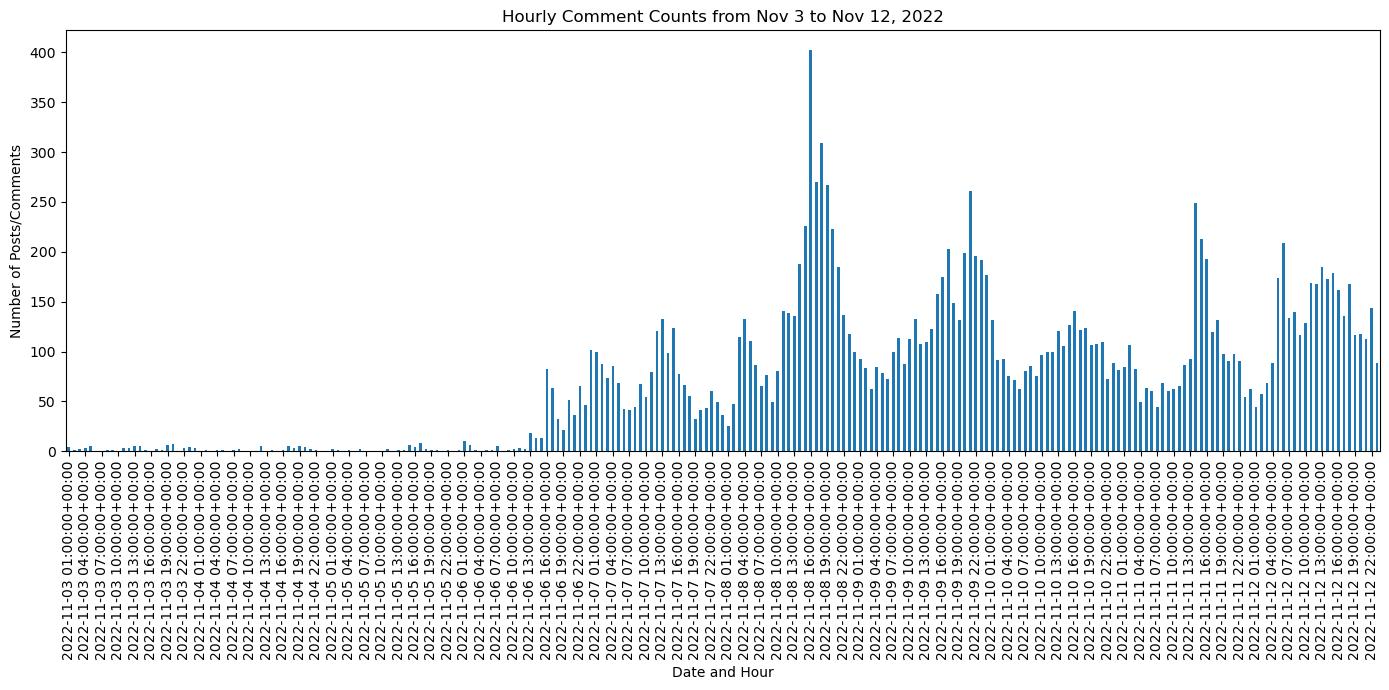

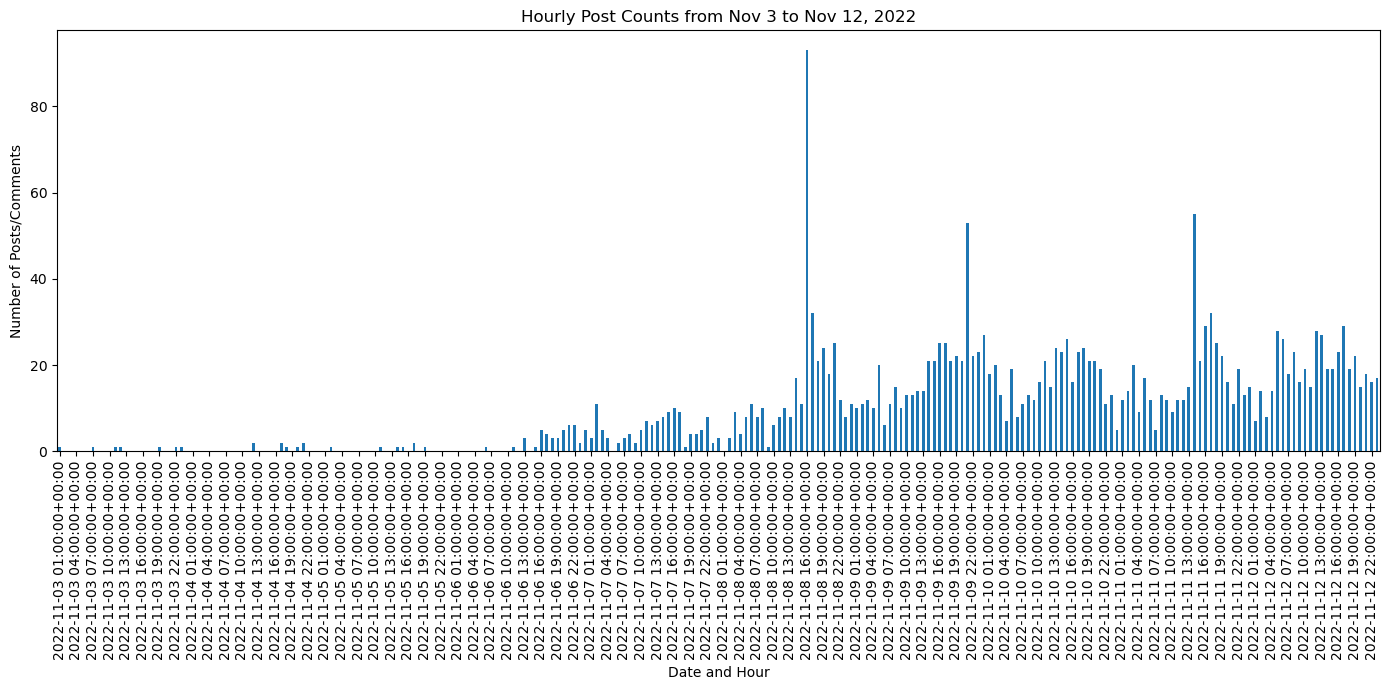

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_prepare_data(file_path):
    df = pd.read_json(file_path, lines=True)
    print(f"Data loaded, total records: {len(df)}")  # Stampa il numero di record caricati
    
    # Controlla il formato delle date mostrando alcuni esempi
    print("Sample dates from file:")
    print(df['created_utc'].head())

    # Converti i timestamp in datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='ms', utc=True)  # Converti da millisecondi
    print("Sample dates after conversion to datetime:")
    print(df['created_utc'].head())

    # Filtra i dati per il range di date desiderato
    mask = (df['created_utc'] >= pd.Timestamp('2022-11-03T00:00:00Z')) & (df['created_utc'] <= pd.Timestamp('2022-11-12T23:59:59Z'))
    df = df.loc[mask]
    print(f"Records after date filtering: {len(df)}")  # Stampa il numero di record dopo il filtraggio per data
    return df


def plot_data(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    # Imposta 'created_utc' come indice
    df.set_index('created_utc', inplace=True)
    # Raggruppa per ora e conta le occorrenze
    hourly_counts = df.resample('H').size()
    
    if hourly_counts.empty:
        print(f"No hourly data to plot for {title}.")
        return

    # Crea il grafico
    plt.figure(figsize=(14, 7))
    hourly_counts.plot(kind='bar')
    plt.xlabel('Date and Hour')
    plt.ylabel('Number of Posts/Comments')
    plt.title(title)
    plt.xticks(rotation=90)  # Ruota le etichette per leggibilità
    # Mostra solo ogni terza etichetta sull'asse x per evitare sovraffollamento
    plt.gca().set_xticks(plt.gca().get_xticks()[::3])
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

if __name__ == "__main__":
    # Percorsi ai file
    comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json"
    posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json"

    # Carica e prepara i dati
    comments_df = load_and_prepare_data(comments_file_path)
    posts_df = load_and_prepare_data(posts_file_path)

    # Plotta i dati
    plot_data(comments_df, 'Hourly Comment Counts from Nov 3 to Nov 12, 2022')
    plot_data(posts_df, 'Hourly Post Counts from Nov 3 to Nov 12, 2022')


Data loaded, total records: 38657
Sample dates from file:
0    1664582415000
1    1664582436000
2    1664583565000
3    1664586333000
4    1664586412000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-10-01 00:00:15+00:00
1   2022-10-01 00:00:36+00:00
2   2022-10-01 00:19:25+00:00
3   2022-10-01 01:05:33+00:00
4   2022-10-01 01:06:52+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 29982
Data loaded, total records: 5241
Sample dates from file:
0    1664590780000
1    1664650514000
2    1664742405000
3    1664781601000
4    1664805084000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-10-01 02:19:40+00:00
1   2022-10-01 18:55:14+00:00
2   2022-10-02 20:26:45+00:00
3   2022-10-03 07:20:01+00:00
4   2022-10-03 13:51:24+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 4137


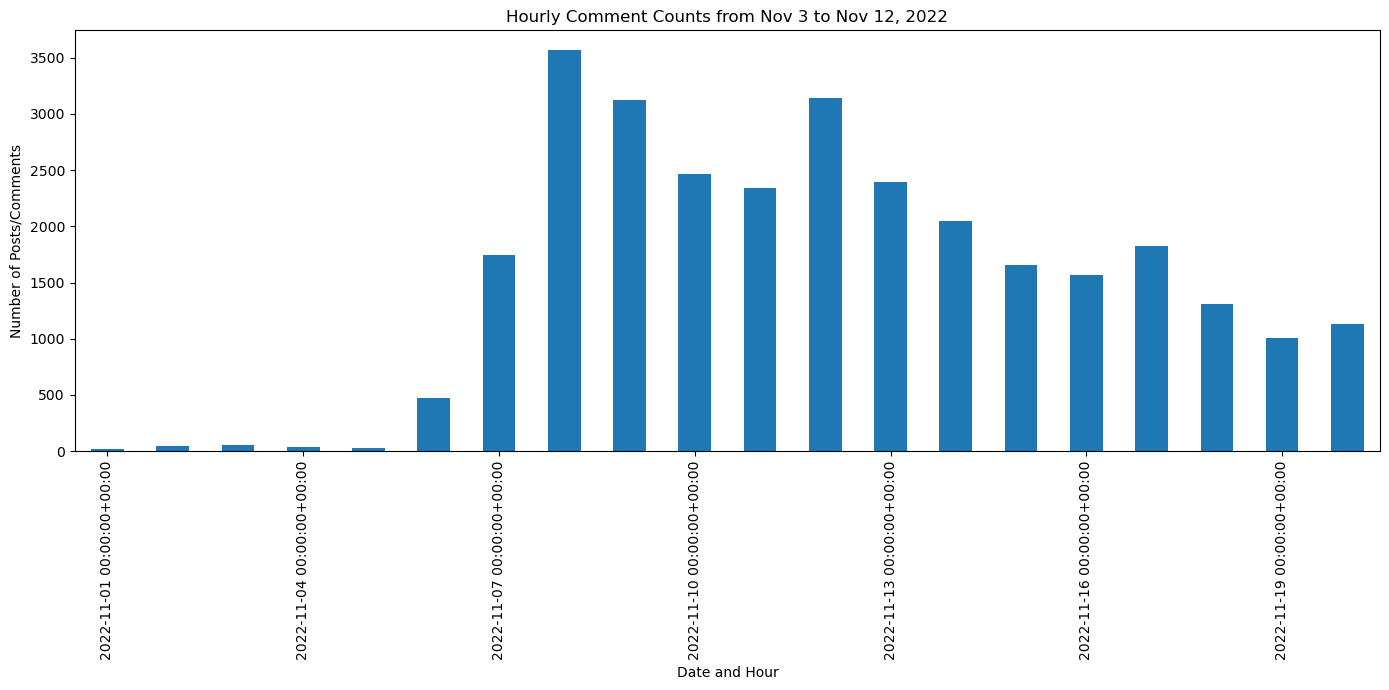

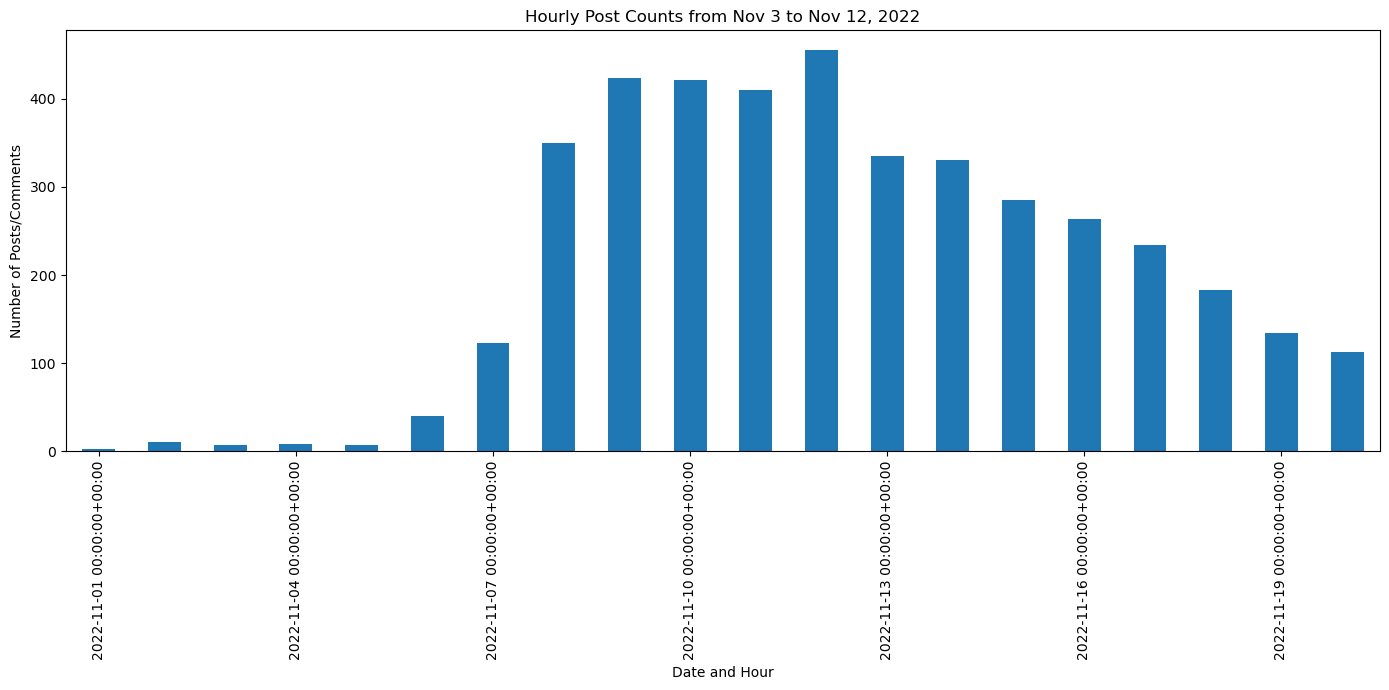

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_prepare_data(file_path):
    df = pd.read_json(file_path, lines=True)
    print(f"Data loaded, total records: {len(df)}")  # Stampa il numero di record caricati
    
    # Controlla il formato delle date mostrando alcuni esempi
    print("Sample dates from file:")
    print(df['created_utc'].head())

    # Converti i timestamp in datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='ms', utc=True)  # Converti da millisecondi
    print("Sample dates after conversion to datetime:")
    print(df['created_utc'].head())

    # Filtra i dati per il range di date desiderato
    mask = (df['created_utc'] >= pd.Timestamp('2022-11-01T00:00:00Z')) & (df['created_utc'] <= pd.Timestamp('2022-11-20T23:59:59Z'))
    df = df.loc[mask]
    print(f"Records after date filtering: {len(df)}")  # Stampa il numero di record dopo il filtraggio per data
    return df


def plot_data(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    # Imposta 'created_utc' come indice
    df.set_index('created_utc', inplace=True)
    # Raggruppa per ora e conta le occorrenze
    hourly_counts = df.resample('D').size()
    
    if hourly_counts.empty:
        print(f"No hourly data to plot for {title}.")
        return

    # Crea il grafico
    plt.figure(figsize=(14, 7))
    hourly_counts.plot(kind='bar')
    plt.xlabel('Date and Hour')
    plt.ylabel('Number of Posts/Comments')
    plt.title(title)
    plt.xticks(rotation=90)  # Ruota le etichette per leggibilità
    # Mostra solo ogni terza etichetta sull'asse x per evitare sovraffollamento
    plt.gca().set_xticks(plt.gca().get_xticks()[::3])
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

if __name__ == "__main__":
    # Percorsi ai file
    comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json"
    posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json"

    # Carica e prepara i dati
    comments_df = load_and_prepare_data(comments_file_path)
    posts_df = load_and_prepare_data(posts_file_path)

    # Plotta i dati
    plot_data(comments_df, 'Hourly Comment Counts from Nov 3 to Nov 12, 2022')
    plot_data(posts_df, 'Hourly Post Counts from Nov 3 to Nov 12, 2022')

    # Salva il DataFrame combinato in un file CSV (opzionale)
    comments_df.to_csv('numeroCommFtx.csv')
    posts_df.to_csv('numeroPostFtx.csv')


# 2 - Disegnare il grafico del prezzo e sovrapporlo a quello dei post e dei commenti
### Ottenere Dati sui Prezzi da Binance e Yahoo!finance
Per ottenere i dati dei prezzi di unaFTTaho usato:
#### Yahoo!finance
Per i prezzi giornalieri dal 1 ottobre 2022 al 30 novembre 2022:
1. Sono andato su questa [pagina](https://finance.yahoo.com/quote/FTT-USD/history/?period1=1664582400&period2=1669766400&filter=history)
2. Ho selezionato l'intervallo di date desiderato
3. E ho cliccato su download
4. Ho ottenuto il file **FTT-USD.csv**
#### Binance
Per i prezzi a intervalli di 5 min dal 7 novembre 2022 al 10 novembre 2022:
1. Sono andato su questa [pagina](https://www.binance.com/it/landing/data)
2. Mi sono posizionato col mouse su *Index Price K-Line*
3. Ho cliccato *USDⓢ-M*
4. Ho settato i vari parametri:
    - Simbolo: FTTUSDT
    - Intervallo: Daily
    - Granularità: 5m
    - Intervallo di date: 2522-11-09 -> 2022-11-11
    - Dati aggiornati ogni giorno alle 00:00 (UTC+0)
5. Ho scaricato 4 file CSV (uno per og
6. Li ho uniti in un unico file **FTTUSDT-5m.csv**

### Binance (5 min)
| Field Name               | Description                                |
|--------------------------|--------------------------------------------|
| open_time                | Kline Open time in unix time format        |
| open                     | Index Price Open Price                     |
| high                     | Index Price High Price                     |
| low                      | Index Price Low Price                      |
| close                    | Index Price Close Price                    |
| volume                   | Ignore                                     |
| close_time               | Kline Open time in unix time format        |
| quote_volume             | Ignore                                     |
| count                    | Ignore                                     |
| taker_buy_volume         | Ignore                                     |
| taker_buy_quote_volume   | Ignore                                     |
| ignore                   | Ignore                                     |


In [13]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        return readable_date
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
posts_file_path = "C:/Users/giaco/ProgettoIngInf/FTTUSDT-5m.csv"

# Leggi il file CSV in un DataFrame
df = pd.read_csv(posts_file_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df['open_time'] = pd.to_numeric(df['open_time'], errors='coerce')
df['close_time'] = pd.to_numeric(df['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df['open_time'] = df['open_time'].apply(convert_timestamp_to_readable_date)
df['close_time'] = df['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df[['open_time', 'open']])


                open_time       open
0     01:00:00 07-11-2022  22.264196
1     01:05:00 07-11-2022  22.268643
2     01:10:00 07-11-2022  22.414643
3     01:15:00 07-11-2022  22.408546
4     01:20:00 07-11-2022  22.420492
...                   ...        ...
1147  00:35:00 11-11-2022   3.532349
1148  00:40:00 11-11-2022   3.491590
1149  00:45:00 11-11-2022   3.466428
1150  00:50:00 11-11-2022   3.498242
1151  00:55:00 11-11-2022   3.521711

[1152 rows x 2 columns]


Ora prendo il df e plotto il grafico del prezzo
### Grafico del prezzo di FTT (5 min)

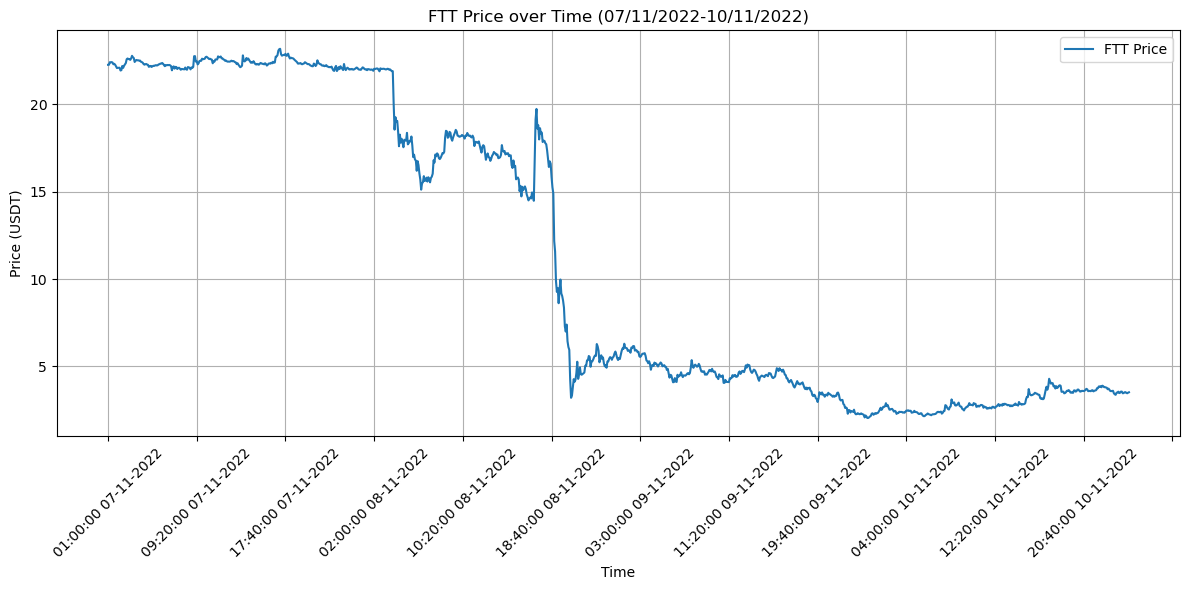

In [14]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assumi che df sia il DataFrame già caricato e con i timestamp convertiti correttamente

# Seleziona solo le colonne "open_time" e "open" per il grafico
df_filtered = df[['open_time', 'open']]

# Imposta il grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta il grafico del prezzo
ax.plot(df_filtered['open_time'], df_filtered['open'], label='FTT Price')

# Imposta etichette e titolo
ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title('FTT Price over Time (07/11/2022-10/11/2022)')
ax.legend()

# Imposta formattazione dell'asse x per visualizzare solo un dato ogni 100
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))

# Imposta la rotazione delle etichette dell'asse x
plt.xticks(rotation=45)

# Imposta il layout e mostra la griglia
plt.tight_layout()
ax.grid()

# Mostra il grafico
plt.show()


### Yahoo!finance (daily)

In [10]:
import pandas as pd
import datetime

# Percorso del file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/FTT-USD.csv"

# Leggi il file CSV in un DataFrame
df_d = pd.read_csv(file_path)

# Eliminare le colonne non necessarie
df_d.drop(columns=['AdjClose'] , inplace=True) # AdjClose è sempre uguale a Close

# Visualizzare le prime righe del DataFrame risultante
print(df_d)

          Date       Open       High        Low      Close    Volume
0   2022-10-01  24.235086  24.439743  23.998938  24.283325  47612081
1   2022-10-02  24.284882  24.357561  23.961456  24.032326  37256558
2   2022-10-03  24.032587  24.816563  23.907284  24.763277  80640104
3   2022-10-04  24.762039  25.248720  24.623304  25.117477  67348735
4   2022-10-05  25.117712  25.140430  24.447199  24.777027  45601574
..         ...        ...        ...        ...        ...       ...
56  2022-11-26   1.401195   1.429898   1.349244   1.364939  43773375
57  2022-11-27   1.364506   1.384601   1.315469   1.315469   7301184
58  2022-11-28   1.315751   1.329345   1.281961   1.295093   6250102
59  2022-11-29   1.294036   1.322258   1.278124   1.303769   4903379
60  2022-11-30   1.304239   1.479522   1.302395   1.339892  17522894

[61 rows x 6 columns]


### Grafico del prezzo di FTT (daily)

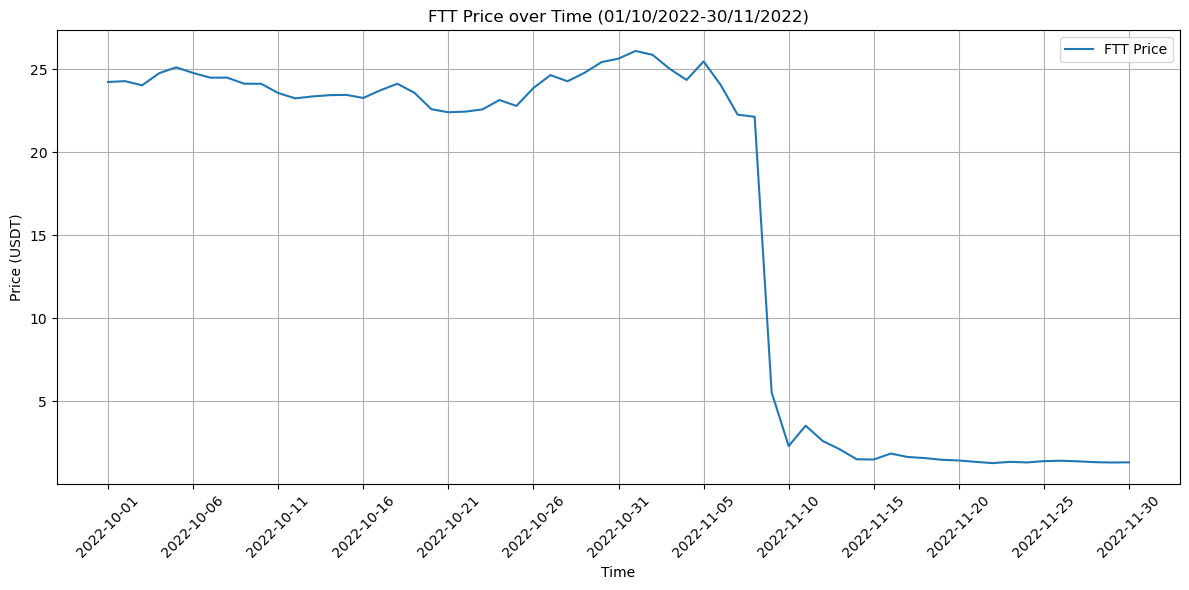

In [11]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assumi che df sia il DataFrame già caricato e con i timestamp convertiti correttamente

# Seleziona solo le colonne "open_time" e "open" per il grafico
df_d_filtered = df_d[['Date', 'Open']]

# Imposta il grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta il grafico del prezzo
ax.plot(df_d_filtered['Date'], df_d_filtered['Open'], label='FTT Price')

# Imposta etichette e titolo
ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title('FTT Price over Time (01/10/2022-30/11/2022)')
ax.legend()

# Imposta formattazione dell'asse x per visualizzare solo un dato ogni 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

# Imposta la rotazione delle etichette dell'asse x
plt.xticks(rotation=45)

# Imposta il layout e mostra la griglia
plt.tight_layout()
ax.grid()

# Mostra il grafico
plt.show()


### Grafico numero post - prezzo FTT
Prendere il grafico del numero di post e plottarlo insieme al grafico del prezzo.

Prendo il df del numero di post e prendo le date 2022/11/5 1:00 - 2022/11/11 1:00 :

In [15]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        # readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        # return readable_date
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
price_path = "C:/Users/giaco/ProgettoIngInf/FTTUSDT-5m-2022-11.csv"

# Leggi il file CSV in un DataFrame
df_price_nov = pd.read_csv(price_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df_price_nov['open_time'] = pd.to_numeric(df_price_nov['open_time'], errors='coerce')
df_price_nov['close_time'] = pd.to_numeric(df_price_nov['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df_price_nov['open_time'] = df_price_nov['open_time'].apply(convert_timestamp_to_readable_date)
df_price_nov['close_time'] = df_price_nov['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df_price_nov.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df_price_nov[['open_time', 'open']])


               open_time       open
0    2022-11-01 01:00:00  26.101074
1    2022-11-01 01:05:00  26.057295
2    2022-11-01 01:10:00  26.052392
3    2022-11-01 01:15:00  26.091950
4    2022-11-01 01:20:00  26.062990
...                  ...        ...
8635 2022-12-01 00:35:00   1.333325
8636 2022-12-01 00:40:00   1.329950
8637 2022-12-01 00:45:00   1.334167
8638 2022-12-01 00:50:00   1.331967
8639 2022-12-01 00:55:00   1.334867

[8640 rows x 2 columns]


Tengo solo i dati del prezzo nell'intervallo di date 2022/11/5 1:00 - 2022/11/11 1:00 :

In [16]:
# Definisci le date di inizio e fine
start_date = datetime.datetime(2022, 11, 5, 1, 0, 0)
end_date = datetime.datetime(2022, 11, 11, 1, 0, 0)

# Filtra i dati
df_price_nov_filtered = df_price_nov[(df_price_nov['open_time'] >= start_date) & (df_price_nov['open_time'] <= end_date)]

# Visualizza le prime righe del DataFrame filtrato
print(df_price_nov_filtered[['open_time', 'open']])

               open_time       open
1152 2022-11-05 01:00:00  25.458385
1153 2022-11-05 01:05:00  25.479344
1154 2022-11-05 01:10:00  25.373900
1155 2022-11-05 01:15:00  25.376863
1156 2022-11-05 01:20:00  25.382101
...                  ...        ...
2876 2022-11-11 00:40:00   3.491590
2877 2022-11-11 00:45:00   3.466428
2878 2022-11-11 00:50:00   3.498242
2879 2022-11-11 00:55:00   3.521711
2880 2022-11-11 01:00:00   3.502524

[1729 rows x 2 columns]


Prendo i dati dei post dal file json e tengo solo le date che mi interessano e sommo il numero di post a intervalli di 30 min:

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
json_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json"
df_json = pd.read_json(json_file_path, lines=True)

# Converte 'created_utc' in datetime e filtra per il range di date
df_json['created_utc'] = pd.to_datetime(df_json['created_utc'], unit='ms')
start_date = datetime(2022, 11, 5, 1, 0, 0)
end_date = datetime(2022, 11, 11, 1, 0, 0)
df_json_filtered = df_json[(df_json['created_utc'] >= start_date) & (df_json['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json_filtered.set_index('created_utc', inplace=True)
df_counts = df_json_filtered.resample('30T').size()


Preparo il grafico del numero di post:

(array([19301., 19302., 19303., 19304., 19305., 19306., 19307.]),
 [Text(19301.0, 0, '2022-11-05'),
  Text(19302.0, 0, '2022-11-06'),
  Text(19303.0, 0, '2022-11-07'),
  Text(19304.0, 0, '2022-11-08'),
  Text(19305.0, 0, '2022-11-09'),
  Text(19306.0, 0, '2022-11-10'),
  Text(19307.0, 0, '2022-11-11')])

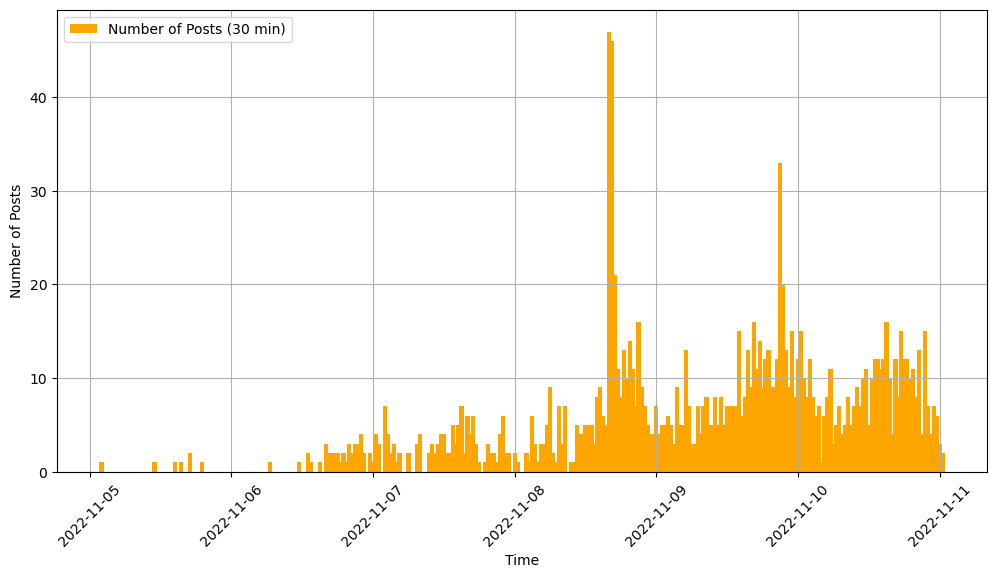

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df_counts.index, df_counts, width=0.03, label='Number of Posts (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)


Combino i due grafici:

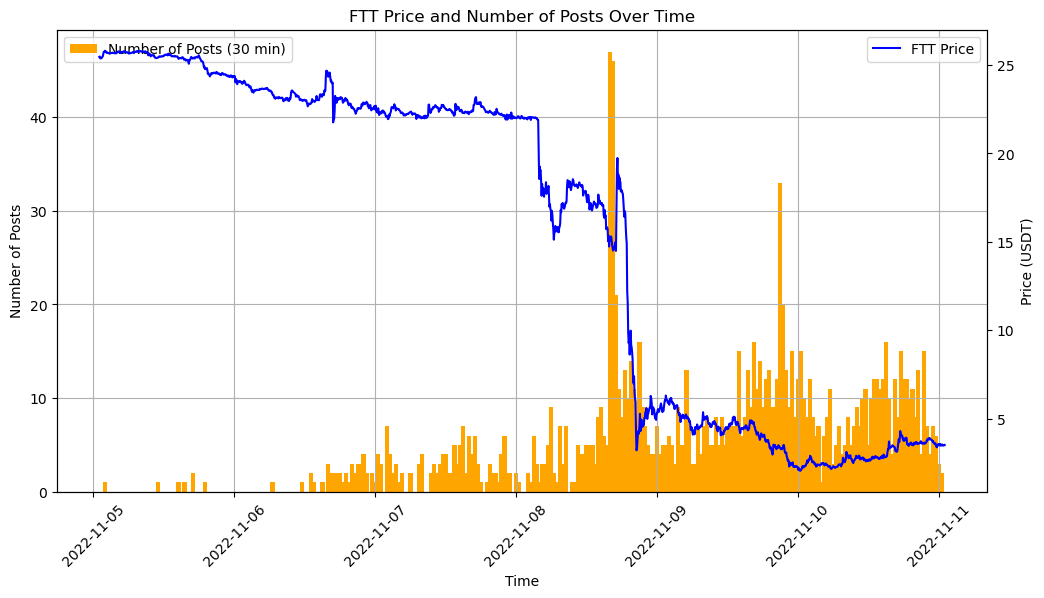

In [16]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.03, label='Number of Posts (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT Price and Number of Posts Over Time')
plt.show()

## Grafico post + commenti + prezzo

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
json_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json"
df_json_com = pd.read_json(json_file_path, lines=True)

# Converte 'created_utc' in datetime e filtra per il range di date
df_json_com['created_utc'] = pd.to_datetime(df_json_com['created_utc'], unit='ms')
start_date = datetime(2022, 11, 5, 1, 0, 0)
end_date = datetime(2022, 11, 11, 1, 0, 0)
df_json__com_filtered = df_json_com[(df_json_com['created_utc'] >= start_date) & (df_json_com['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json__com_filtered.set_index('created_utc', inplace=True)
df_counts_com = df_json__com_filtered.resample('30T').size()


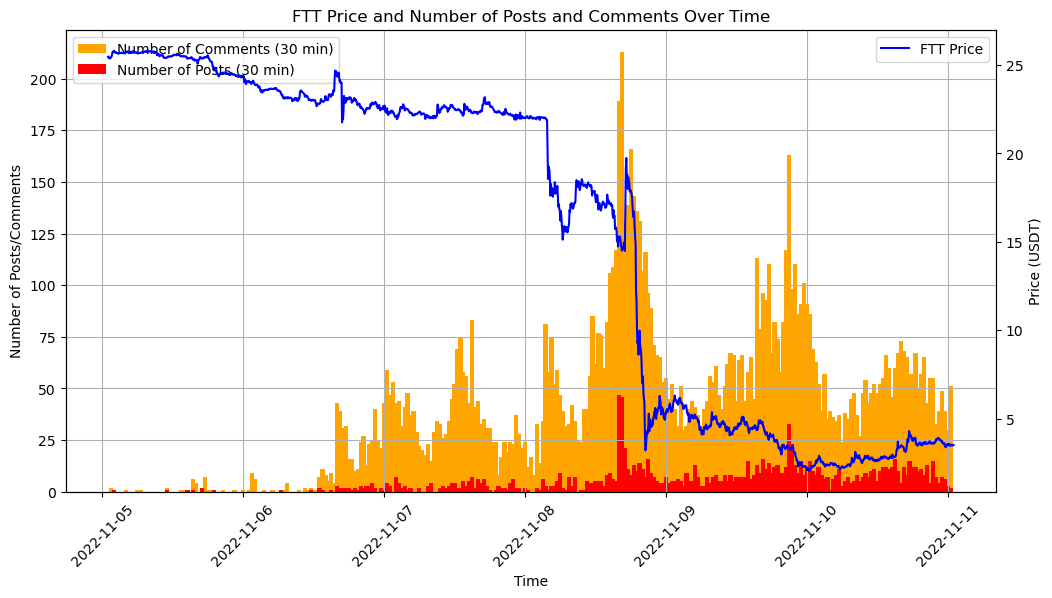

In [18]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.03, label='Number of Posts (30 min)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT Price and Number of Posts and Comments Over Time')
plt.show()

# Lista dei vari data frame disponibili
* **df_counts_com** : numero di **commenti** ogni 30 minuti
* **df_counts** : numero di **post** ogni 30 minuti
* **df_price_nov_filtered** : **prezzo** di ftt a granularità 5 minuti

Tutti i dati sono nel periodo (2022/11/5 1:00 - 2022/11/11 1:00)

# 4 - Aggiungere PyTrends al grafico

In [99]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


Ho scaricato i file csv direttamente da **Google Trends** perché pytrends contunuava a darmi errore 429

In [19]:
# Comparare il numero di ricerche di FTX con quello dell'argomento "matita" (pencil)

# Grafico nel tempo
timeline_path = "C:/Users/giaco/ProgettoIngInf/multiTimelineFtx_1.csv"
timeline_path_2 = "C:/Users/giaco/ProgettoIngInf/googleTrendsFtx1.csv"
# Suddivisione geografica delle ricerche con le relative percentuali
geoMap_path = "C:/Users/giaco/ProgettoIngInf/geoMapFtx_1.csv"

df_trend_time = pd.read_csv(timeline_path)
df_trend_time_2 = pd.read_csv(timeline_path_2)
df_trend_geo = pd.read_csv(geoMap_path)


![alt text](geoMapFtxMat.png "Title")

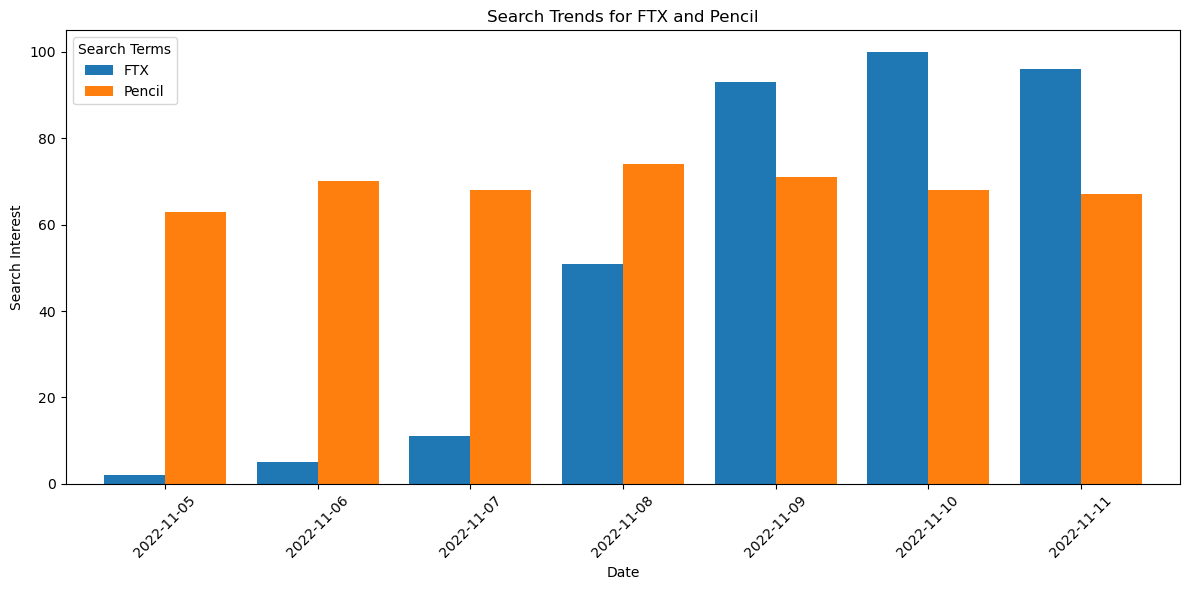

In [20]:
# Convert the 'Giorno' column to datetime
df_trend_time['Giorno'] = pd.to_datetime(df_trend_time['Giorno'])

# Set the 'Tempo' column as the index
df_trend_time.set_index('Giorno', inplace=True)

# Plot the data as a bar chart with two columns for each date
ax = df_trend_time.plot(kind='bar', figsize=(12, 6), width=0.8)

# Format x-axis to show only dates
ax.set_xticklabels(df_trend_time.index.strftime('%Y-%m-%d'))

# Set the title and labels
plt.title('Search Trends for FTX and Pencil')
plt.xlabel('Date')
plt.ylabel('Search Interest')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend(title='Search Terms')

# Show the plot
plt.tight_layout()
plt.show()

## I top 10 paesi per ricerche di FTX nel periodo 5/11/2022 - 11/11/2022

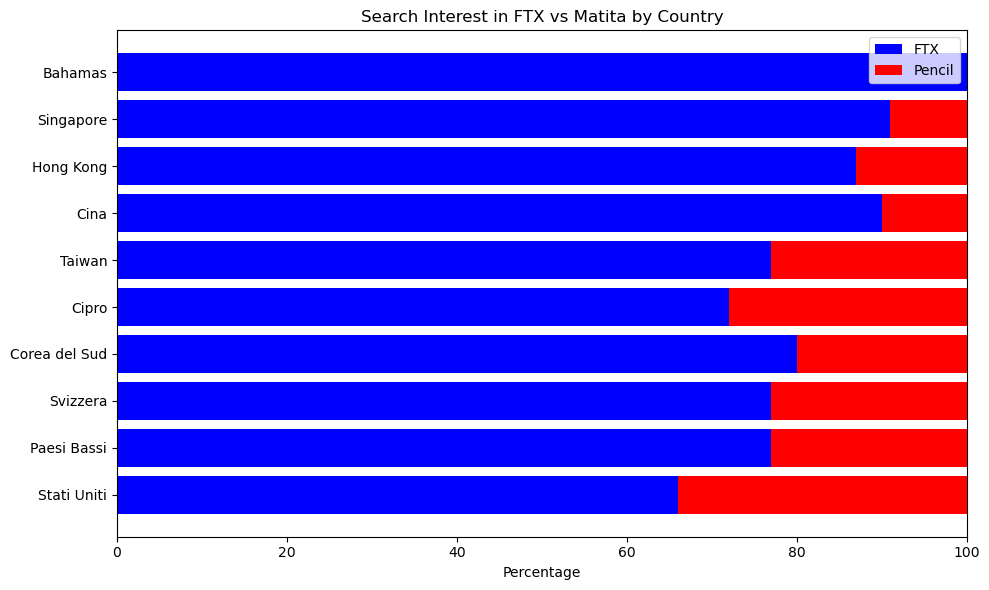

In [21]:
# Clean the data: remove the '%' and convert to numeric values
df_trend_geo['FTX'] = df_trend_geo['FTX'].str.rstrip('%').astype(float)
df_trend_geo['Pencil'] = df_trend_geo['Pencil'].str.rstrip('%').astype(float)

# Select the top 10 countries for visualization
top_10_countries = df_trend_geo.head(10)
top_10_countries = top_10_countries.iloc[::-1]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bars
bars1 = ax.barh(top_10_countries['Country'], top_10_countries['FTX'], color='blue', label='FTX')
bars2 = ax.barh(top_10_countries['Country'], top_10_countries['Pencil'], left=top_10_countries['FTX'], color='red', label='Pencil')

# Add labels
ax.set_xlabel('Percentage')
ax.set_title('Search Interest in FTX vs Matita by Country')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


Sam Bankman-Fried, il fondatore ed ex CEO di FTX, ha una connessione significativa con le Bahamas per vari motivi:

1. **Sede di FTX**: FTX ha trasferito la sua sede alle Bahamas nel 2021. Questo spostamento è avvenuto in parte a causa del contesto regolamentare favorevole del paese per le criptovalute e le attività finanziarie innovative. Le Bahamas hanno introdotto una legislazione pro-crypto, il "Digital Assets and Registered Exchanges (DARE) Act", che ha reso il paese un luogo attraente per gli exchange di criptovalute.

2. **Residenza di Sam Bankman-Fried**: Sam Bankman-Fried e alcuni membri chiave del team di FTX si sono trasferiti alle Bahamas. Era noto che Bankman-Fried risiedeva in un lussuoso attico situato a Nassau, la capitale delle Bahamas.

3. **Eventi e attività locali**: FTX ha organizzato vari eventi e iniziative alle Bahamas per promuovere la propria attività e per contribuire alla comunità locale. La presenza di FTX nel paese ha avuto un impatto significativo sull'economia locale, creando posti di lavoro e stimolando l'innovazione tecnologica.

Questi fattori spiegano perché le Bahamas sono strettamente legate a Sam Bankman-Fried e a FTX.

In [22]:
import pandas as pd

# Controlla le colonne del DataFrame
print("Colonne del DataFrame:", df_trend_time_2.columns)

# Controlla se ci sono spazi bianchi nei nomi delle colonne
df_trend_time_2.columns = df_trend_time_2.columns.str.strip()

# Stampa le prime righe del DataFrame
print(df_trend_time_2.head())

# Assicurati che la colonna 'Tempo' sia presente e corretta
if 'Tempo' in df_trend_time_2.columns:
    # Converti la colonna 'Tempo' in un formato datetime
    df_trend_time_2['Tempo'] = pd.to_datetime(df_trend_time_2['Tempo'], format='%Y-%m-%dT%H')
    # Setta la colonna 'Tempo' come indice
    df_trend_time_2.set_index('Tempo', inplace=True)
    print("Conversione e impostazione dell'indice riuscite.")
else:
    print("La colonna 'Tempo' non esiste nel DataFrame.")


Colonne del DataFrame: Index(['Tempo', 'ftx'], dtype='object')
           Tempo  ftx
0  2022-11-05T02    1
1  2022-11-05T03    0
2  2022-11-05T04    1
3  2022-11-05T05    0
4  2022-11-05T06    0
Conversione e impostazione dell'indice riuscite.


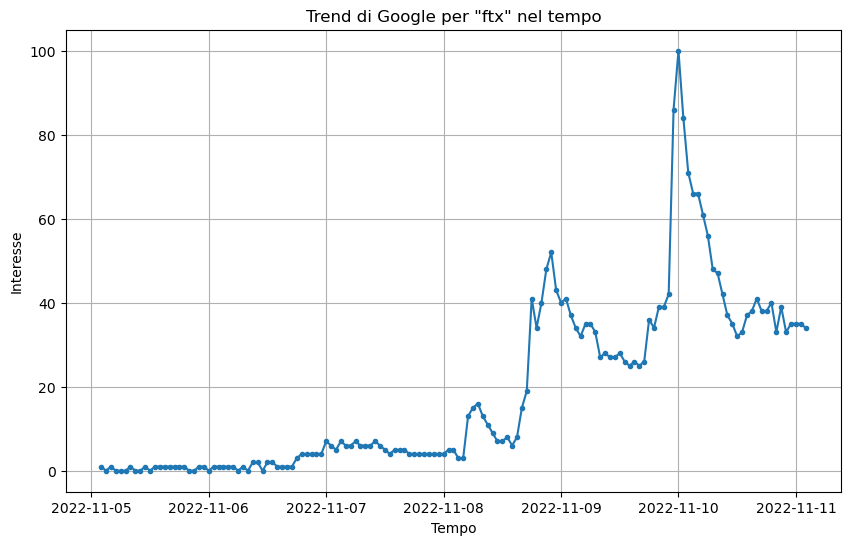

In [23]:
import matplotlib.pyplot as plt

# Esempio di grafico utilizzando la colonna 'Tempo' come indice
plt.figure(figsize=(10, 6))
plt.plot(df_trend_time_2.index, df_trend_time_2['ftx'], marker='.', linestyle='-')
plt.title('Trend di Google per "ftx" nel tempo')
plt.xlabel('Tempo')
plt.ylabel('Interesse')
plt.grid(True)
plt.show()


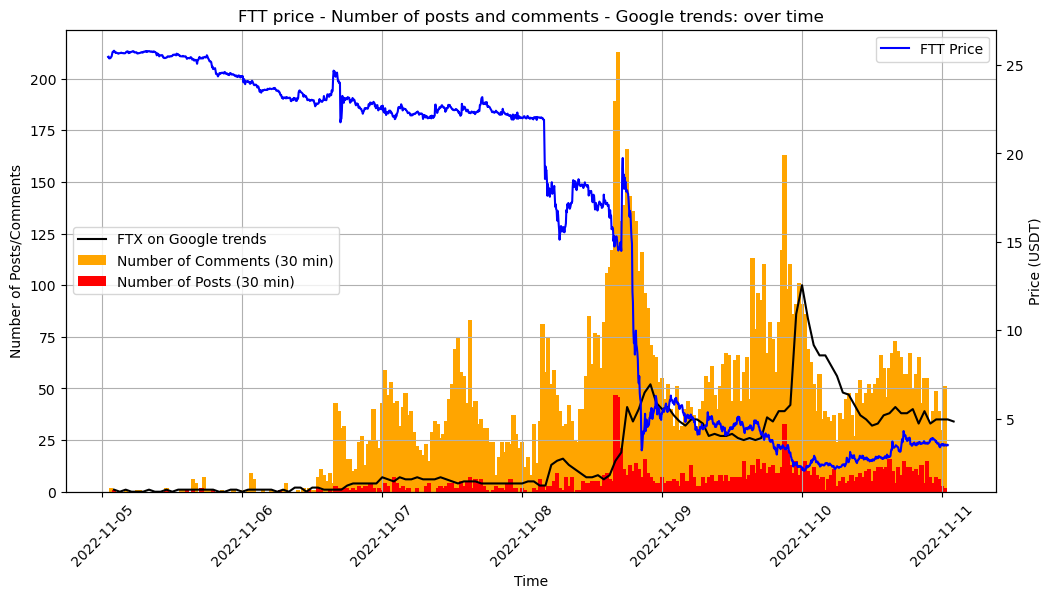

In [24]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.03, label='Number of Posts (30 min)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati
# Convert the 'Tempo' column to datetime

ax1.plot(df_trend_time_2.index, df_trend_time_2['ftx'], label='FTX on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()

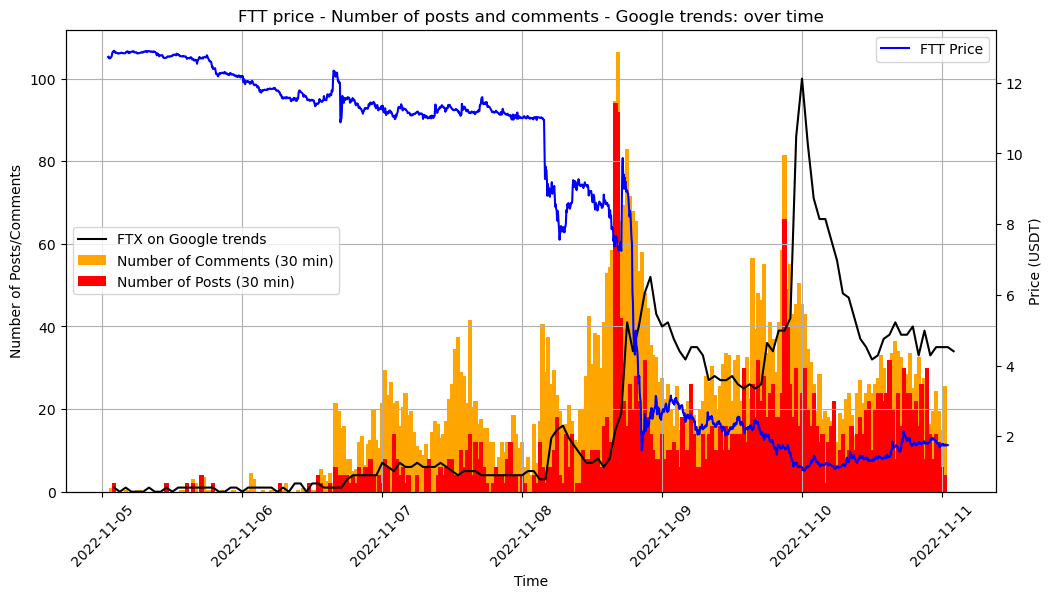

In [19]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com/2, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts*2, width=0.03, label='Number of Posts (30 min)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open']/2, label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati
# Convert the 'Tempo' column to datetime

ax1.plot(df_trend_time_2.index, df_trend_time_2['ftx'], label='FTX on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()

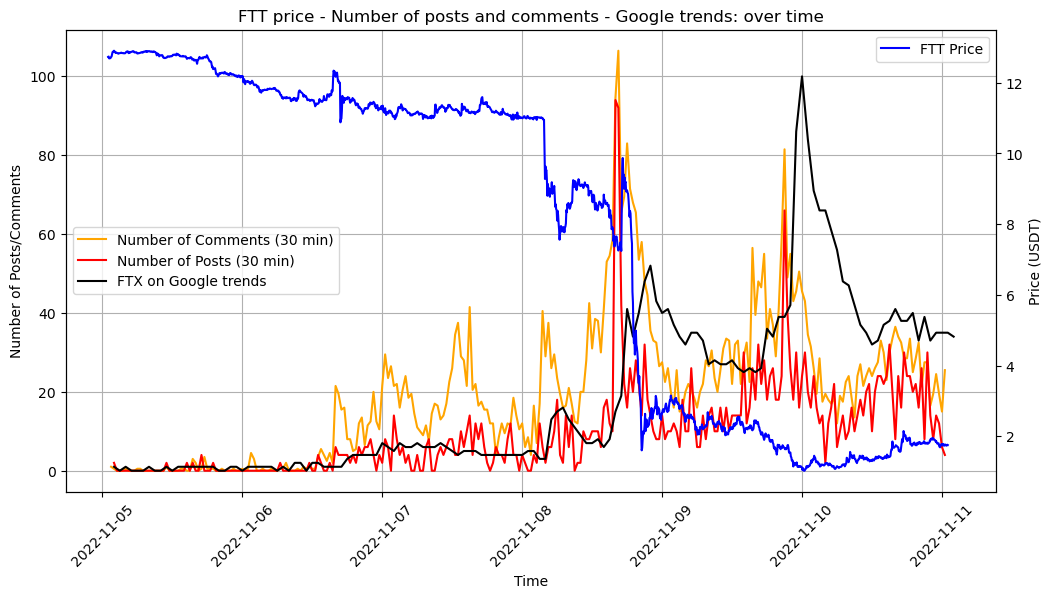

In [131]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta il grafico del numero di commenti ogni 30 minuti
ax1.plot(df_counts_com.index, df_counts_com / 2, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del numero di post ogni 30 minuti
ax1.plot(df_counts.index, df_counts * 2, label='Number of Posts (30 min)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] / 2, label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati di Google Trends
ax1.plot(df_trend_time_2.index, df_trend_time_2['ftx'], label='FTX on Google trends', color='black')
ax1.legend(loc='center left')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()


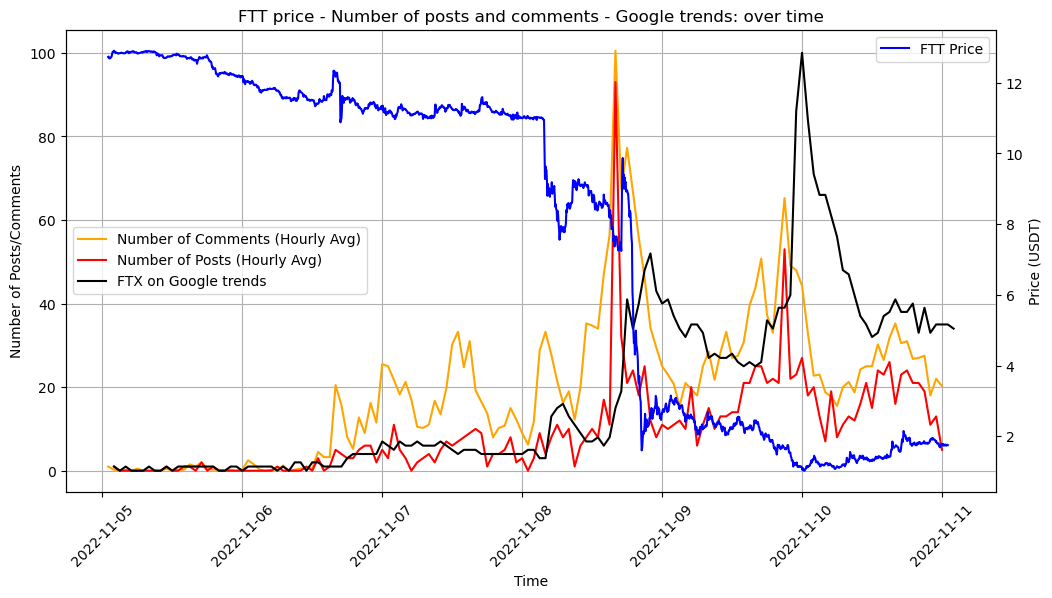

In [142]:
# Raggruppa i dati ogni 60 minuti (1 ora) e calcola la media
df_counts_hourly = df_counts.resample('1H').mean()
df_counts_com_hourly = df_counts_com.resample('1H').mean()

# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta il grafico del numero di commenti ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_com_hourly.index, df_counts_com_hourly / 2, label='Number of Comments (Hourly Avg)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del numero di post ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_hourly.index, df_counts_hourly * 2, label='Number of Posts (Hourly Avg)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] / 2, label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati di Google Trends
ax1.plot(df_trend_time_2.index, df_trend_time_2['ftx'], label='FTX on Google trends', color='black')
ax1.legend(loc='center left')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()


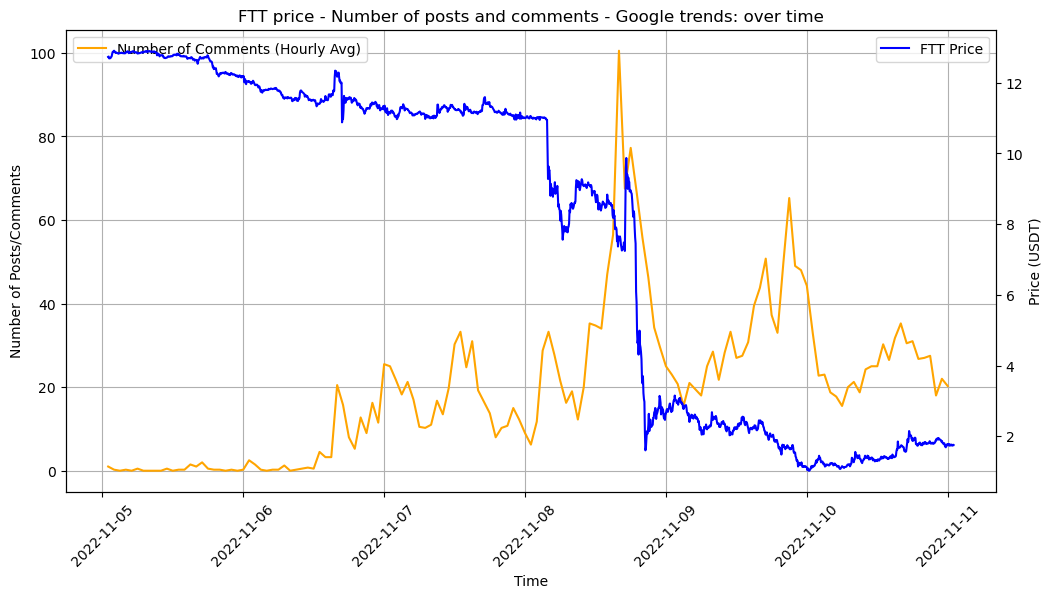

In [143]:
# Raggruppa i dati ogni 60 minuti (1 ora) e calcola la media
df_counts_hourly = df_counts.resample('1H').mean()
df_counts_com_hourly = df_counts_com.resample('1H').mean()

# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta il grafico del numero di commenti ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_com_hourly.index, df_counts_com_hourly / 2, label='Number of Comments (Hourly Avg)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] / 2, label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()


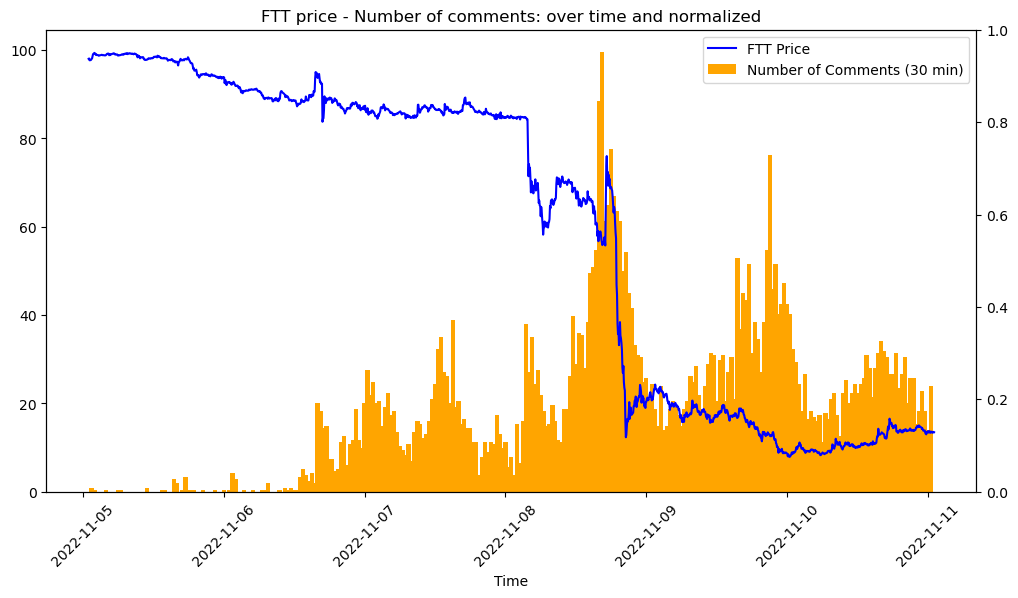

In [218]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com/2.138, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax1.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] * 3.85 , label='FTT Price', color='blue')
ax1.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of comments: over time and normalized')
plt.show()


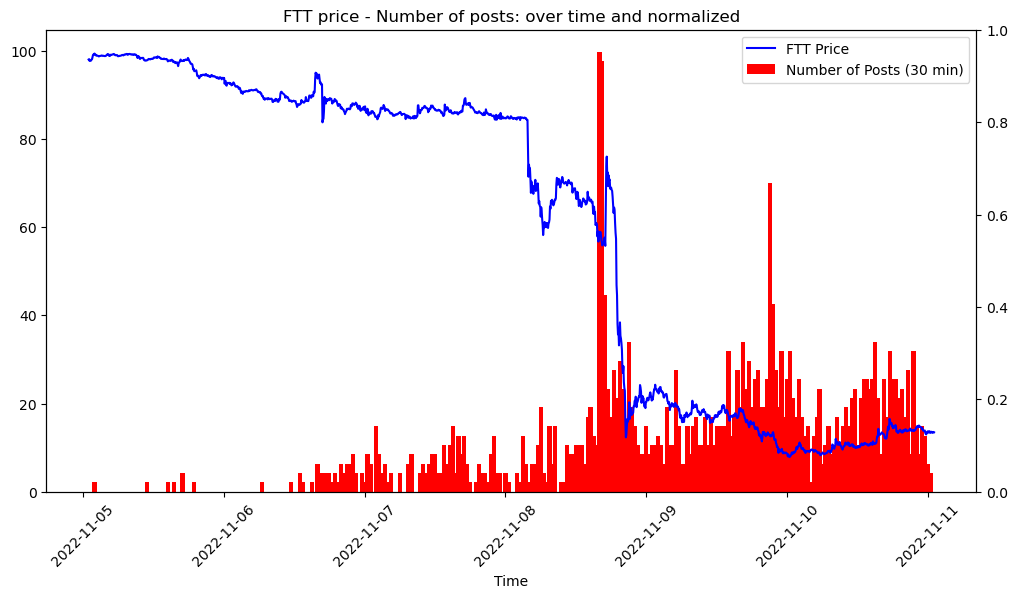

In [216]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts*2.123, width=0.03, label='Number of Posts (30 min)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax1.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] * 3.85 , label='FTT Price', color='blue')
ax1.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts: over time and normalized')
plt.show()


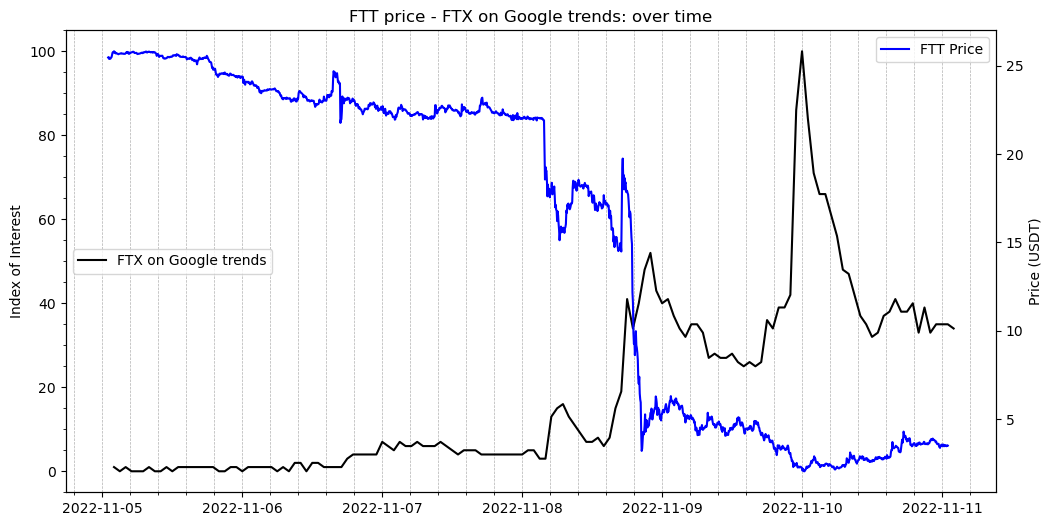

In [42]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori


ax1.plot(df_trend_time_2.index, df_trend_time_2['ftx'], label='FTX on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
#ax1.grid(True)
ax1.set_ylabel('Index of Interest')
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
#ax1.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] * 3.85 , label='FTT Price', color='blue')
ax2.legend(loc='upper right')
ax2.set_ylabel('Price (USDT)')



# Mostra il grafico combinato
plt.title('FTT price - FTX on Google trends: over time')
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
com_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json"
df_json_com = pd.read_json(com_file_path, lines=True)
# Carica i dati dal file JSON
post_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json"
df_json_post = pd.read_json(post_file_path, lines=True)

start_date = datetime(2022, 11, 5, 1, 0, 0)
end_date = datetime(2022, 11, 11, 1, 0, 0)
# Converte 'created_utc' in datetime e filtra per il range di date
df_json_com['created_utc'] = pd.to_datetime(df_json_com['created_utc'], unit='ms')
df_json_com_filtered = df_json_com[(df_json_com['created_utc'] >= start_date) & (df_json_com['created_utc'] <= end_date)]
# Converte 'created_utc' in datetime e filtra per il range di date
df_json_post['created_utc'] = pd.to_datetime(df_json_post['created_utc'], unit='ms')
df_json_post_filtered = df_json_post[(df_json_post['created_utc'] >= start_date) & (df_json_post['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json_com_filtered.set_index('created_utc', inplace=True)
df_counts_com = df_json_com_filtered.resample('2H').size()
# Raggruppa i dati ogni 30 minuti
df_json_post_filtered.set_index('created_utc', inplace=True)
df_counts_post = df_json_post_filtered.resample('2H').size()

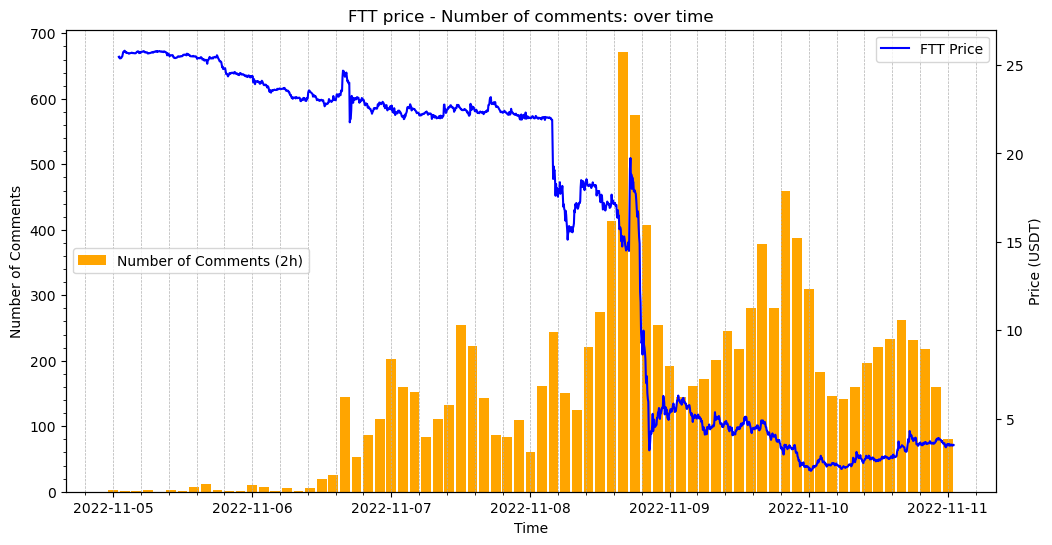

In [43]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.07, label='Number of Comments (2h)', color='orange')
#ax1.bar(df_counts_com.index, df_counts_com/6.77, width=0.07, label='Number of Comments (2h)', color='orange')
#ax1.bar(df_counts_com.index, df_counts_com/9, width=0.1, label='Number of Comments (3h)', color='orange')
ax1.set_xlabel('Time')
ax1.legend(loc='center left')
ax1.set_ylabel('Number of Comments')
#ax1.grid(True)
#plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
#ax1.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] * 3.85 , label='FTT Price', color='blue')
ax2.legend(loc='upper right')
ax2.set_ylabel('Price (USDT)')

# Mostra il grafico combinato
plt.title('FTT price - Number of comments: over time')
plt.show()

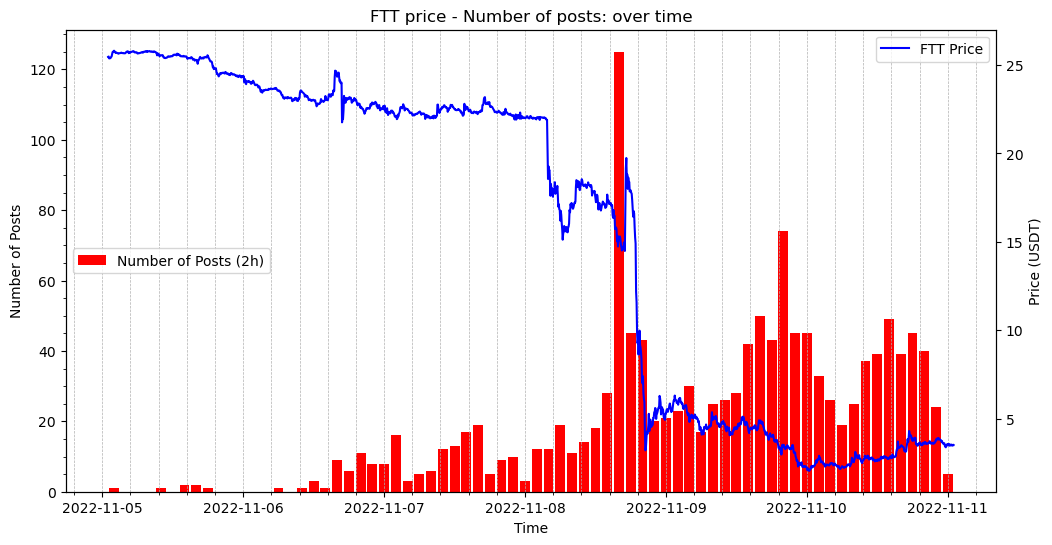

In [44]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts_post.index, df_counts_post, width=0.07, label='Number of Posts (2h)', color='red')
#ax1.bar(df_counts_post.index, df_counts_post/1.25, width=0.07, label='Number of Posts (2h)', color='red')
#ax1.bar(df_counts_post.index, df_counts_post/1.362, width=0.1, label='Number of Posts (3h)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='center left')
ax1.set_ylabel('Number of Posts')
#ax1.grid(True)
#plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
#ax1.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] * 3.85 , label='FTT Price', color='blue')
ax2.legend(loc='upper right')
ax2.set_ylabel('Price (USDT)')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts: over time')
plt.show()


<h1 style="text-align: center;">Analisi del sentiment</h1>

# 5 - Unire i commenti e i post tramite l'id
Creo due tabelle:
1. Il post con il suo id, l'autore e lo score
2. I commenti con id del post, data e ora

Da queste due tabelle ne creo una terza con id del post, numero commenti, score, e poi con (da vedere) ad esempio tre colonne con tre valori di tempo, e per ogni valore indico il numero di commenti che sono stati fatti sotto a quel determinato post entro un certo periodo di tempo.


## Tabella 1

#### Passo 1: Caricare i dati da JSON
Carica i dati dei post e dei commenti in due DataFrame pandas separati...

In [69]:
# Carica i dati dei post
df_posts = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json", lines=True)
# Carica i dati dei commenti
df_comments = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json", lines=True)

#### Passo 2: Preparare le tabelle
Estrai le informazioni rilevanti dai DataFrame e prepara le due tabelle iniziali come specificato.

In [70]:
# Assicurati che i campi 'created_utc' siano convertiti correttamente da millisecondi a secondi
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'], unit='ms')
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'], unit='ms')

In [71]:
# Prepara le tabelle dei post e dei commenti
posts_table = df_posts[['id', 'author', 'score', 'num_comments', 'created_utc']]
comments_table = df_comments[['link_id', 'created_utc']]

#### Passo 3: Creare una tabella combinata
Unisci i commenti e i post tramiteidDe link_id (llink_id nei commenti corrisponde a id nei pos senza il t3_ all'iniziot) e calcola il numero di commenti per ciascun intervallo di tempo specificat.

Collegamento con i Post

* *link_id* :  Questo campo identifica il post a cui il commento è associato. Generalment, inizia con "t3_" seguito da un identificativo unico
* *parent_id* : : Se il commento è una risposta ad un altro commento, questo campo mostra l'ID del commento originale. Se inizia con "t1_", si riferisce a un commento; se inizia con "t3_", si riferisce a un post..

In [72]:
# Rimuovi il prefisso 't3_' dai link_id per ottenere solo l'id del post utilizzando .loc per evitare SettingWithCopyWarning
comments_table.loc[:, 'link_id'] = comments_table['link_id'].str.replace('t3_', '')

# Unisci i DataFrame in base all'id del post
merged_df = comments_table.merge(posts_table, left_on='link_id', right_on='id', how='inner')

# Visualizza il DataFrame unito
print(merged_df)

      link_id       created_utc_x      id                author  score  \
0      xsjhtn 2022-10-01 02:19:40  xsjhtn    belligerent_pickle      1   
1      xt36fo 2022-10-01 18:55:49  xt36fo               Yoshie5      5   
2      xt36fo 2022-10-01 18:58:10  xt36fo               Yoshie5      5   
3      xt36fo 2022-10-01 19:03:34  xt36fo               Yoshie5      5   
4      xt36fo 2022-10-01 19:07:03  xt36fo               Yoshie5      5   
...       ...                 ...     ...                   ...    ...   
24516  z88pys 2022-11-29 22:54:29  z88pys       Always_Question     11   
24517  z88n4c 2022-11-29 23:10:06  z88n4c  Imaginary-Adagio2231      0   
24518  z88n4c 2022-11-29 23:21:36  z88n4c  Imaginary-Adagio2231      0   
24519  z88n4c 2022-11-29 23:30:23  z88n4c  Imaginary-Adagio2231      0   
24520  z88n4c 2022-11-29 23:57:13  z88n4c  Imaginary-Adagio2231      0   

       num_comments       created_utc_y  
0                 1 2022-10-01 02:19:40  
1                22 2022-10

#### Passo 4: Associo a ciascun post il numero di commenti ricevuti in diversi intervalli temporali
Creo un data frame che contiene i conteggi dei commenti per ogni intervallo di tempo (1h, 6h, 24h, 48h, restanti (fino al 12/11/2022).
Aggiungo una colonna total_comments che è la somma delle colonne degli intervalli di tempo (comments_1h, comments_6h, comments_24h, comments_48h, comments_remaining).
Num_comments contiene il numero di commenti del post (senza limiti di tempo).

In [73]:
# Calcola la differenza di tempo tra la pubblicazione del post e il commento
merged_df['time_diff'] = (merged_df['created_utc_x'] - merged_df['created_utc_y']).dt.total_seconds() / 3600

# Funzione per contare i commenti negli intervalli di tempo
def count_comments_in_interval(df, start_hour, end_hour):
    return ((df['time_diff'] > start_hour) & (df['time_diff'] <= end_hour)).sum()

# Crea un DataFrame per conservare i conteggi dei commenti per ogni intervallo
interval_counts = merged_df.groupby('id').apply(lambda x: pd.Series({
    'comments_1h': count_comments_in_interval(x, 0, 1),
    'comments_6h': count_comments_in_interval(x, 1, 6),
    'comments_24h': count_comments_in_interval(x, 6, 24),
    'comments_48h': count_comments_in_interval(x, 24, 48),
    'comments_remaining': (x['time_diff'] > 48).sum()
})).reset_index()

# Aggiungi una colonna per il totale dei commenti
interval_counts['total_comments'] = interval_counts[['comments_1h', 'comments_6h', 'comments_24h', 'comments_48h', 'comments_remaining']].sum(axis=1)

# Unisci i conteggi al DataFrame dei post
result = posts_table.merge(interval_counts, on='id', how='left')

# Visualizza il risultato
print(result)

          id                author  score  num_comments         created_utc  \
0     xsjhtn    belligerent_pickle      1             1 2022-10-01 02:19:40   
1     xt36fo               Yoshie5      5            22 2022-10-01 18:55:14   
2     xtyw8y        OneThatNoseOne     18            36 2022-10-02 20:26:45   
3     xuchon           KingKDDavid      0             8 2022-10-03 07:20:01   
4     xuk1un            YuntHunter     18            78 2022-10-03 13:51:24   
...      ...                   ...    ...           ...                 ...   
5236  z88n4c  Imaginary-Adagio2231      0            18 2022-11-29 22:41:10   
5237  z88pgq             [deleted]      0             1 2022-11-29 22:43:41   
5238  z88pys       Always_Question     11            31 2022-11-29 22:44:12   
5239  z897uk                 aibra    136           138 2022-11-29 23:02:26   
5240  z89y5w       ravensfreak0624      9            24 2022-11-29 23:30:27   

      comments_1h  comments_6h  comments_24h  comme

                open_time       open
0     02:00:00 01-10-2022  24.244783
1     02:15:00 01-10-2022  24.305358
2     02:30:00 01-10-2022  24.325862
3     02:45:00 01-10-2022  24.198145
4     03:00:00 01-10-2022  24.239094
...                   ...        ...
5755  23:45:00 30-11-2022   1.344066
5756  00:00:00 01-12-2022   1.336417
5757  00:15:00 01-12-2022   1.324625
5758  00:30:00 01-12-2022   1.328900
5759  00:45:00 01-12-2022   1.334167

[5760 rows x 2 columns]


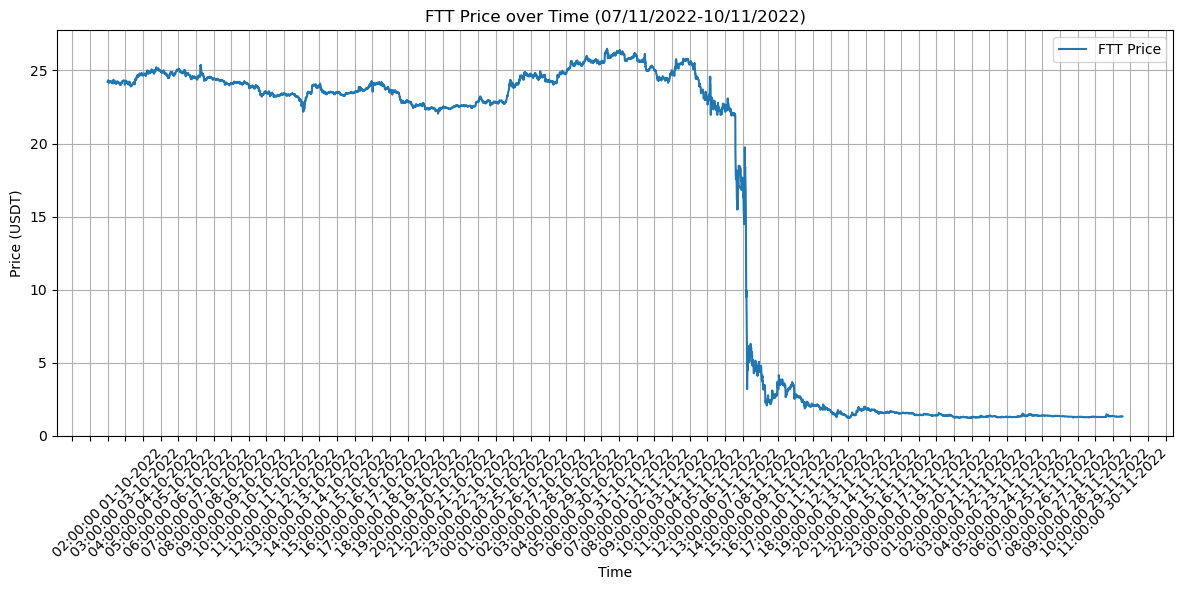

In [74]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        return readable_date
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
posts_file_path = "C:/Users/giaco/ProgettoIngInf/FTT2mesi.csv"

# Leggi il file CSV in un DataFrame
df = pd.read_csv(posts_file_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df['open_time'] = pd.to_numeric(df['open_time'], errors='coerce')
df['close_time'] = pd.to_numeric(df['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df['open_time'] = df['open_time'].apply(convert_timestamp_to_readable_date)
df['close_time'] = df['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df[['open_time', 'open']])

# Assumi che df sia il DataFrame già caricato e con i timestamp convertiti correttamente

# Seleziona solo le colonne "open_time" e "open" per il grafico
df_filtered = df[['open_time', 'open']]

# Imposta il grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta il grafico del prezzo
ax.plot(df_filtered['open_time'], df_filtered['open'], label='FTT Price')

# Imposta etichette e titolo
ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title('FTT Price over Time (07/11/2022-10/11/2022)')
ax.legend()

# Imposta formattazione dell'asse x per visualizzare solo un dato ogni 100
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))

# Imposta la rotazione delle etichette dell'asse x
plt.xticks(rotation=45)

# Imposta il layout e mostra la griglia
plt.tight_layout()
ax.grid()

# Mostra il grafico
plt.show()


In [75]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        # readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        # return readable_date
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
price_path = "C:/Users/giaco/ProgettoIngInf/FTT2mesi.csv"

# Leggi il file CSV in un DataFrame
df_price_nov = pd.read_csv(price_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df_price_nov['open_time'] = pd.to_numeric(df_price_nov['open_time'], errors='coerce')
df_price_nov['close_time'] = pd.to_numeric(df_price_nov['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df_price_nov['open_time'] = df_price_nov['open_time'].apply(convert_timestamp_to_readable_date)
df_price_nov['close_time'] = df_price_nov['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df_price_nov.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df_price_nov[['open_time', 'open']])

               open_time       open
0    2022-10-01 02:00:00  24.244783
1    2022-10-01 02:15:00  24.305358
2    2022-10-01 02:30:00  24.325862
3    2022-10-01 02:45:00  24.198145
4    2022-10-01 03:00:00  24.239094
...                  ...        ...
5755 2022-11-30 23:45:00   1.344066
5756 2022-12-01 00:00:00   1.336417
5757 2022-12-01 00:15:00   1.324625
5758 2022-12-01 00:30:00   1.328900
5759 2022-12-01 00:45:00   1.334167

[5760 rows x 2 columns]


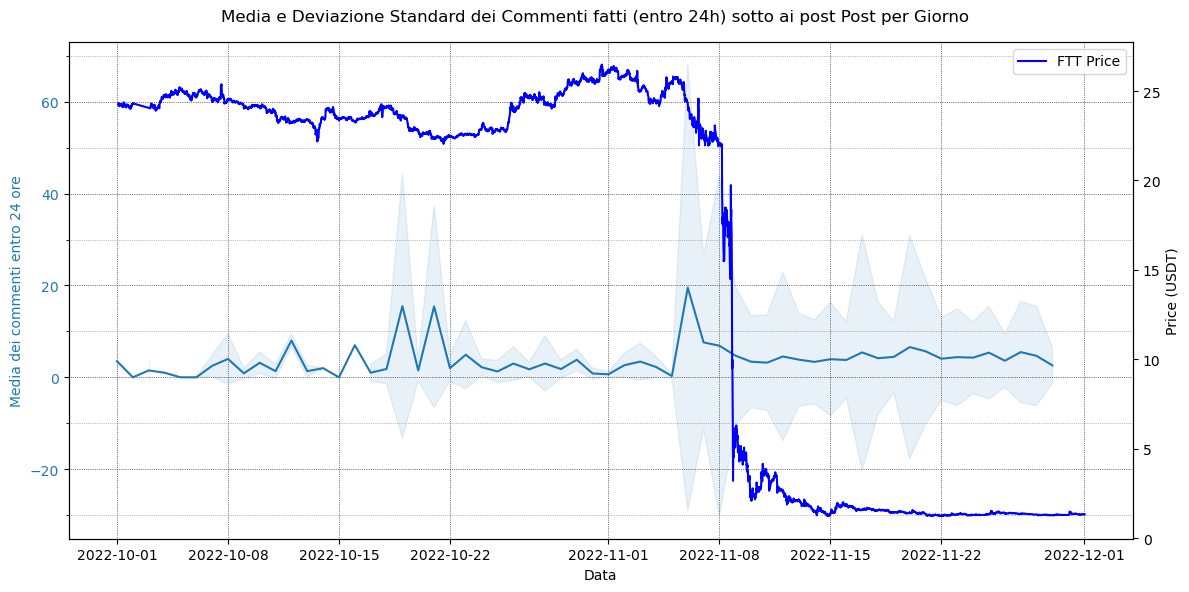

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che il dataframe risultante sia chiamato 'result'
# Creiamo la colonna 'comments_24h_total'
result['comments_24h_total'] = result[['comments_1h', 'comments_6h', 'comments_24h']].sum(axis=1)

# Estraiamo la data dal timestamp 'created_utc' e aggiungiamo una colonna 'date'
result['date'] = result['created_utc'].dt.date

# Raggruppiamo per giorno e calcoliamo la media, la varianza e la deviazione standard dei commenti entro 24 ore
daily_stats = result.groupby('date')['comments_24h_total'].agg(['mean', 'var', 'std']).reset_index()

# Rinominiamo le colonne per chiarezza
daily_stats.columns = ['date', 'mean_comments_24h', 'var_comments_24h', 'std_comments_24h']

# Creiamo le colonne per la deviazione standard superiore e inferiore
daily_stats['upper_std'] = daily_stats['mean_comments_24h'] + daily_stats['std_comments_24h']
daily_stats['lower_std'] = daily_stats['mean_comments_24h'] - daily_stats['std_comments_24h']

# Salva il DataFrame combinato in un file CSV (opzionale)
daily_stats.to_csv('mediaDeviazioneComm_ftx.csv')

# Creiamo il grafico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico della media dei commenti per post al giorno
ax1.set_xlabel('Data')
ax1.set_ylabel('Media dei commenti entro 24 ore', color='tab:blue')
ax1.plot(daily_stats['date'], daily_stats['mean_comments_24h'], color='tab:blue', label='Media dei commenti entro 24 ore')
ax1.fill_between(daily_stats['date'], daily_stats['lower_std'], daily_stats['upper_std'], color='tab:blue', alpha=0.1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov['open_time'], df_price_nov['open'], label='FTT Price', color='blue')
ax2.legend(loc='upper right')
ax2.set_ylabel('Price (USDT)')

#ax1.grid(which='both', axis='both', linestyle='--', linewidth=0.5)

# Aggiungere griglia principale
ax1.grid(which='major', linestyle=':', linewidth='0.5', color='black')

# Aggiungere griglia minore
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Impostare le linee della griglia minore
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Più linee verticali minori
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Più linee orizzontali minori

# Aggiungiamo un titolo e le legende
fig.suptitle('Media e Deviazione Standard dei Commenti fatti (entro 24h) sotto ai post Post per Giorno')
fig.tight_layout()  # Per evitare sovrapposizioni di etichette
plt.show()


#### Passo 5: Salvo i primi 1000 post per numero di commenti ricevuti entro il 12/11/2022

In [132]:
# Ordina il DataFrame in base al totale dei commenti in ordine decrescente
result_sorted = result.sort_values(by='total_comments', ascending=False)

# Prendi i top 1000 post con più commenti
top_1000_posts = result_sorted.head(1000)

# Visualizza il risultato
print(top_1000_posts)

          id               author  score  num_comments         created_utc  \
460   ypl4a9  MediumAdhesiveness5    584          3565 2022-11-08 12:44:54   
3750  yxq8s2       OlivencaENossa   9940          1997 2022-11-17 13:27:43   
2060  ysxikf             dopef123   5562          1931 2022-11-12 05:28:43   
522   ypqy2z    bakraofwallstreet   2773          1250 2022-11-08 16:18:46   
4250  z041pu    norrissifford8474   9528          1815 2022-11-20 13:24:12   
...      ...                  ...    ...           ...                 ...   
1139  yqygjd              Solutar     74            43 2022-11-09 23:04:59   
4817  z3u87j            Charon751     21            40 2022-11-24 20:48:32   
5118  z7arqp         moonkingdome      3            26 2022-11-28 22:26:59   
2881  yutfc3       weakpastasauce      6            16 2022-11-14 09:01:28   
4825  z3wi3y             partymsl     24            47 2022-11-24 22:29:22   

      comments_1h  comments_6h  comments_24h  comments_48h  \
4

Il post con più commenti:
https://www.reddit.com/r/CryptoCurrency/comments/ypl4a9/ftx_megathread/

In [133]:
# Salva il DataFrame in un file CSV
top_1000_posts.to_csv('top_1000_posts.csv', index=False)

# 6 - Analisi del sentiment con Vader

In [1]:
import pandas as pd
from datetime import datetime, timedelta

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json", lines=True)
# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
# Nei commenti tengo: {"body","created_utc","score","controversiality","link_id"}
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)
# Nei post tengo: "score","selftext","author","num_comments","created_utc","title","id"
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
print(comments_df.head())
print(posts_df.head())


                                                body         created_utc  \
0  #Solana Pro-Arguments\nBelow is an argument wr... 2022-10-01 02:00:15   
1  If it weren’t for FTX I don’t think it would b... 2022-10-01 02:00:36   
2              Elon is to DOGE is what SBF is to SOL 2022-10-01 02:19:25   
3  Brace for incoming excuses.  VCs and FTX gunna... 2022-10-01 03:05:33   
4            Rumour is that SBF is looking to buy it 2022-10-01 03:06:52   

   score  controversiality    link_id  
0      0                 0  t3_xsgh4q  
1      2                 0  t3_xsgh4q  
2      1                 0  t3_xsgh4q  
3      2                 0  t3_xsgh4q  
4      1                 0  t3_xsgh4q  
   score                                           selftext  \
0      1                                          [removed]   
1      5                                                      
2     18  Quite a number of people have come out and sai...   
3      0                                           

-> Controversiality contiene valori 0 o 1:

In [62]:
# Converti la colonna 'controversiality' in tipo intero
comments_df['controversiality'] = comments_df['controversiality'].astype(int)

# Filtra le righe dove 'controversiality' è diverso da 0
comments_df = comments_df[comments_df['controversiality'] != 0]

# Visualizzare le prime righe del DataFrame risultante per verificare
# print(comments_df[['created_utc', 'controversiality']].head())
print(comments_df[comments_df['controversiality'] > 0]['controversiality'])

19       1
168      1
201      1
327      1
481      1
        ..
38519    1
38522    1
38525    1
38615    1
38654    1
Name: controversiality, Length: 908, dtype: int32


In [63]:
pip install vaderSentiment

   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   --------- ----------------------------- 30.7/126.0 kB 435.7 kB/s eta 0:00:01
   ---------------------------------------  122.9/126.0 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 126.0/126.0 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Raccolgo i dati del sentiment in un file csv, dove ho la data con anche l'ora del post/commento e il valore di sentiment (neutro, positivo, negativo) assegnato a quel post:

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Funzione per classificare il sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json", lines=True)
# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment'] = comments_df['body'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_selftext'] = posts_df['selftext'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))
posts_df['sentiment_title'] = posts_df['title'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment
posts_df['sentiment'] = posts_df.apply(lambda row: row['sentiment_selftext'] if row['sentiment_selftext'] != 'neutral' else row['sentiment_title'], axis=1)

# Creare i DataFrame con le colonne 'created_utc' e 'sentiment'
comments_sentiment_df = comments_df[['created_utc', 'sentiment']]
posts_sentiment_df = posts_df[['created_utc', 'sentiment']]

# Unire i DataFrame dei commenti e dei post
combined_df = pd.concat([comments_sentiment_df, posts_sentiment_df])

# Visualizzare il DataFrame risultante
print(combined_df.head())

# Salva il DataFrame risultante
combined_df.to_csv("sentiment_analysis_results.csv", index=False)


          created_utc sentiment
0 2022-10-01 02:00:15  positive
1 2022-10-01 02:00:36  positive
2 2022-10-01 02:19:25   neutral
3 2022-10-01 03:05:33   neutral
4 2022-10-01 03:06:52   neutral


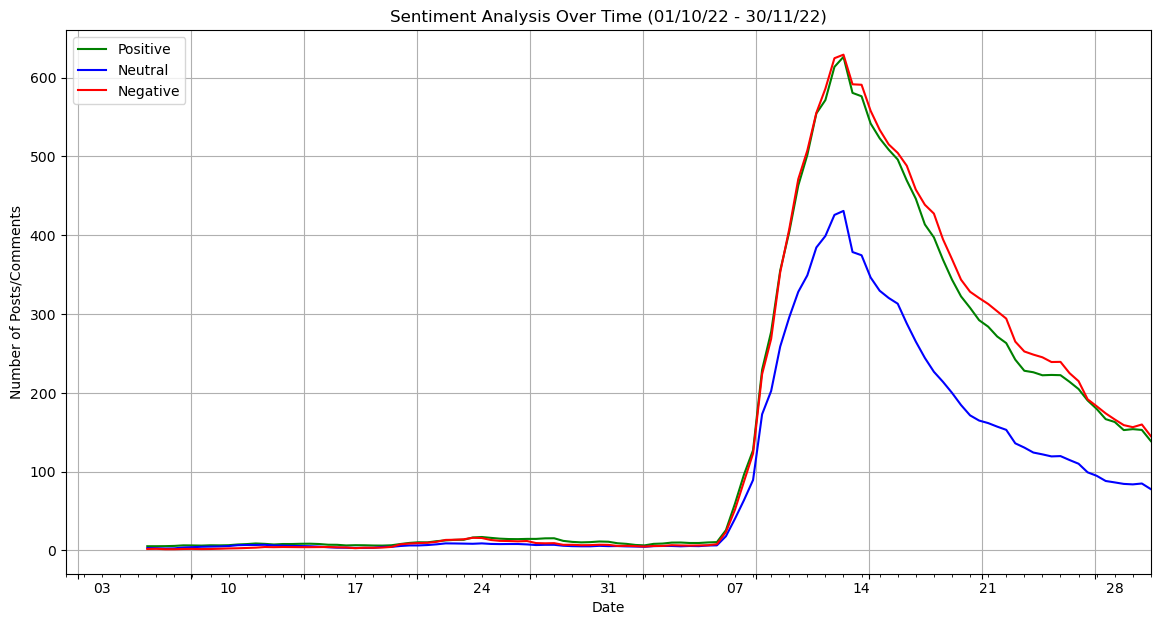

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts/Comments')
ax.set_title('Sentiment Analysis Over Time (01/10/22 - 30/11/22)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


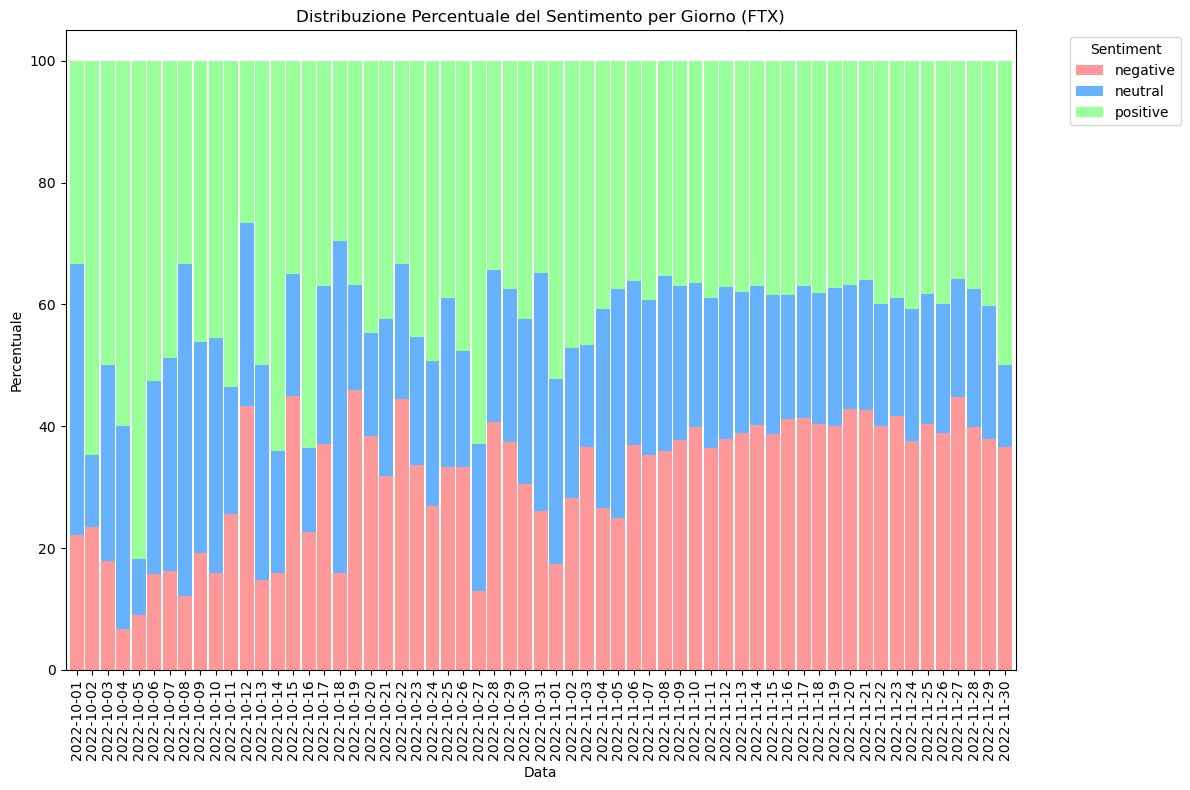

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
df = pd.read_csv(file_path)

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Specifica i colori desiderati
colors = ['#FF9999', '#66B2FF', '#99FF99']  # Rosso, Blu, Verde

# Creazione del barplot cumulato con colori personalizzati
daily_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors, width = 0.9)

plt.title('Distribuzione Percentuale del Sentimento per Giorno (FTX)')
plt.xlabel('Data')
plt.ylabel('Percentuale')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


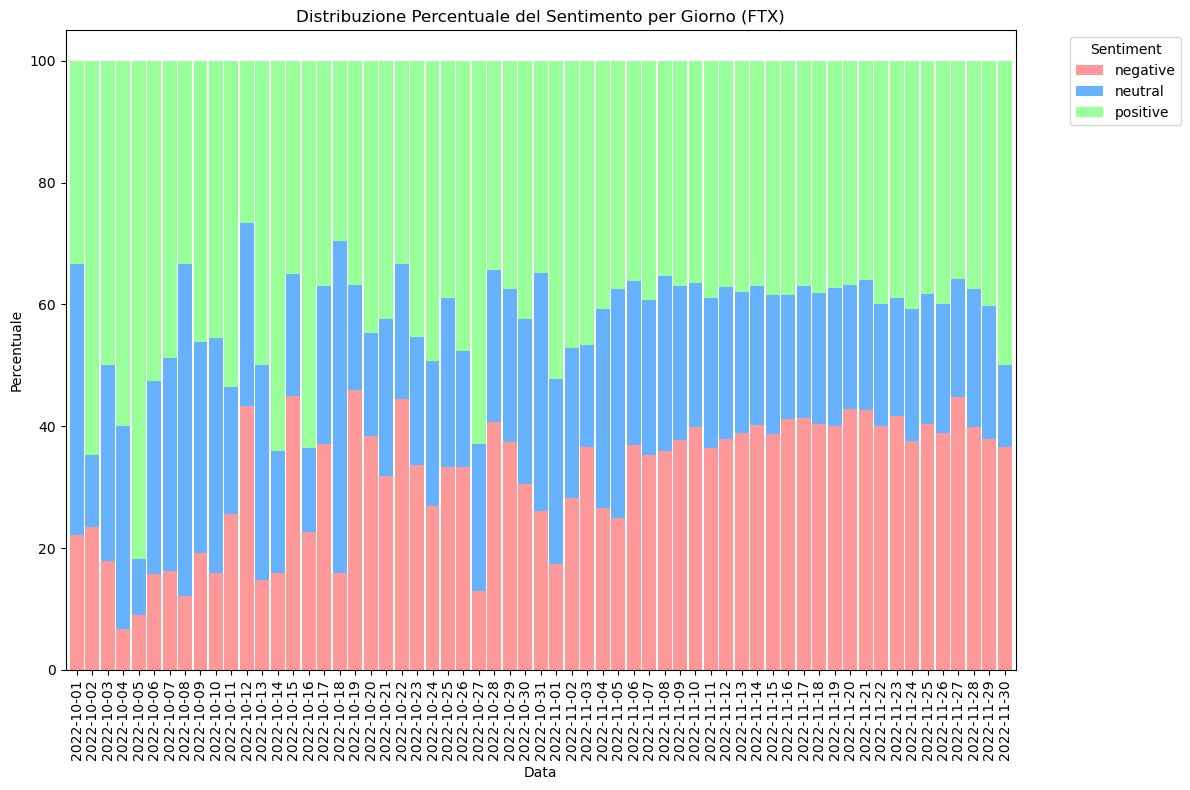

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
df = pd.read_csv(file_path)

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Salva i risultati in un file CSV
output_file_path = "C:/Users/giaco/ProgettoIngInf/sentimentPercentagesFtx.csv"
daily_sentiment_percentages.to_csv(output_file_path, index=True, header=True)

# Specifica i colori desiderati
colors = ['#FF9999', '#66B2FF', '#99FF99']  # Rosso, Blu, Verde

# Creazione del barplot cumulato con colori personalizzati
daily_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors, width=0.9)

plt.title('Distribuzione Percentuale del Sentimento per Giorno (FTX)')
plt.xlabel('Data')
plt.ylabel('Percentuale')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


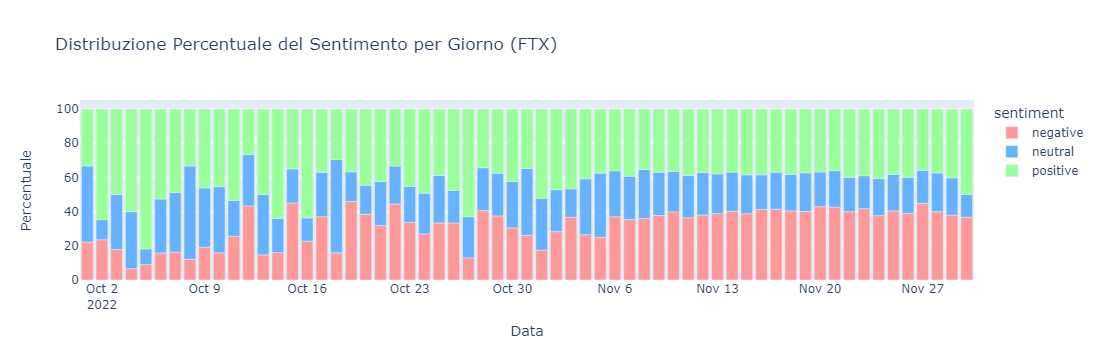

In [4]:
import pandas as pd
import plotly.express as px

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Converte il DataFrame in un formato adatto per Plotly
daily_sentiment_percentages.reset_index(inplace=True)
melted_df = daily_sentiment_percentages.melt(id_vars='date', value_vars=['negative', 'neutral', 'positive'], 
                                             var_name='sentiment', value_name='percentage')

# Creazione del barplot cumulato interattivo con Plotly
fig = px.bar(melted_df, x='date', y='percentage', color='sentiment', 
             title='Distribuzione Percentuale del Sentimento per Giorno (FTX)',
             labels={'percentage': 'Percentuale', 'date': 'Data'},
             color_discrete_map={'negative': '#FF9999', 'neutral': '#66B2FF', 'positive': '#99FF99'})

# Mostra il grafico
fig.show()

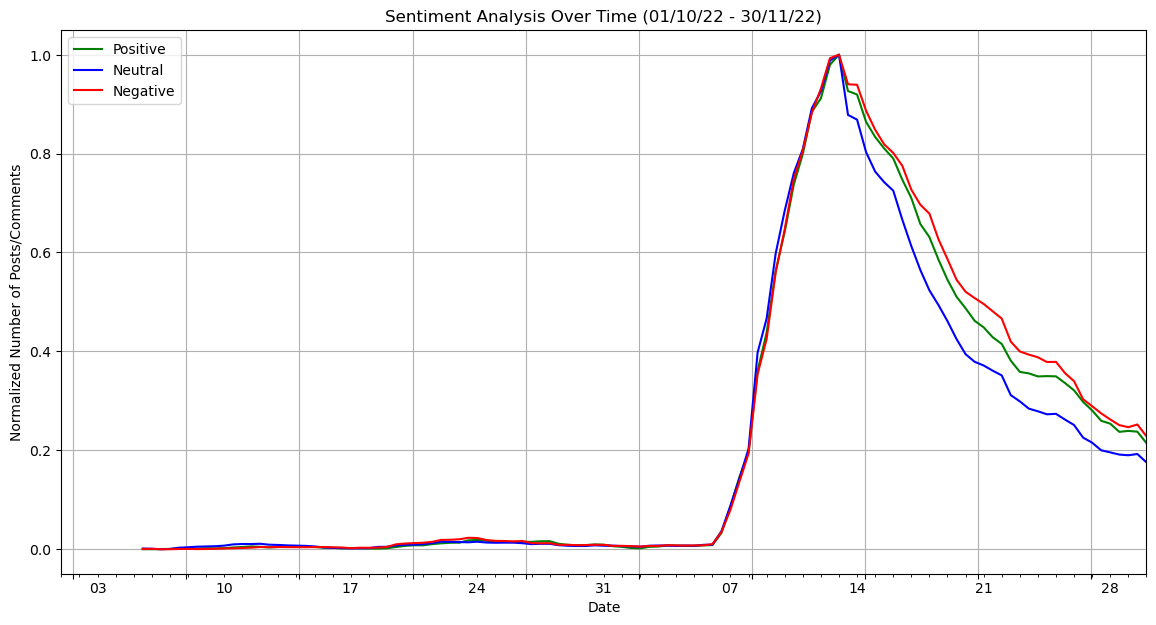

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Normalizza i dati
scaler = MinMaxScaler()
pivot_df[['positive', 'neutral', 'negative']] = scaler.fit_transform(pivot_df[['positive', 'neutral', 'negative']])

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments')
ax.set_title('Sentiment Analysis Over Time (01/10/22 - 30/11/22)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


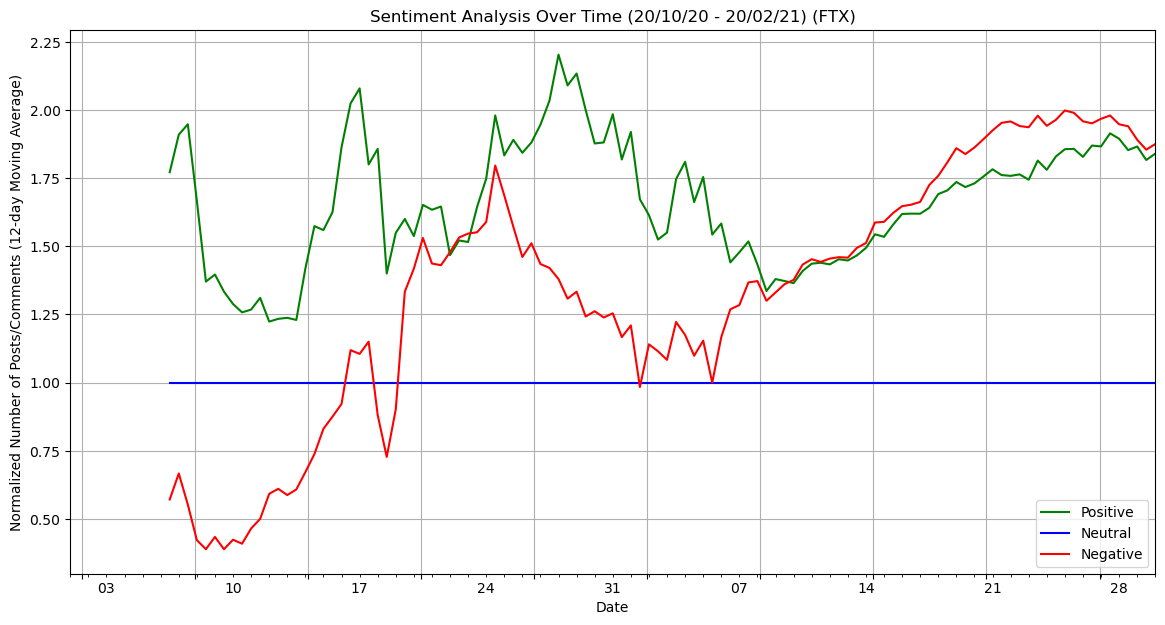

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=12).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=12).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=12).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
#pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/2.2
#pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/2.2
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])
#pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (12-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21) (FTX)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)
ax.legend(loc='lower right')

# Mostra il grafico
plt.show()


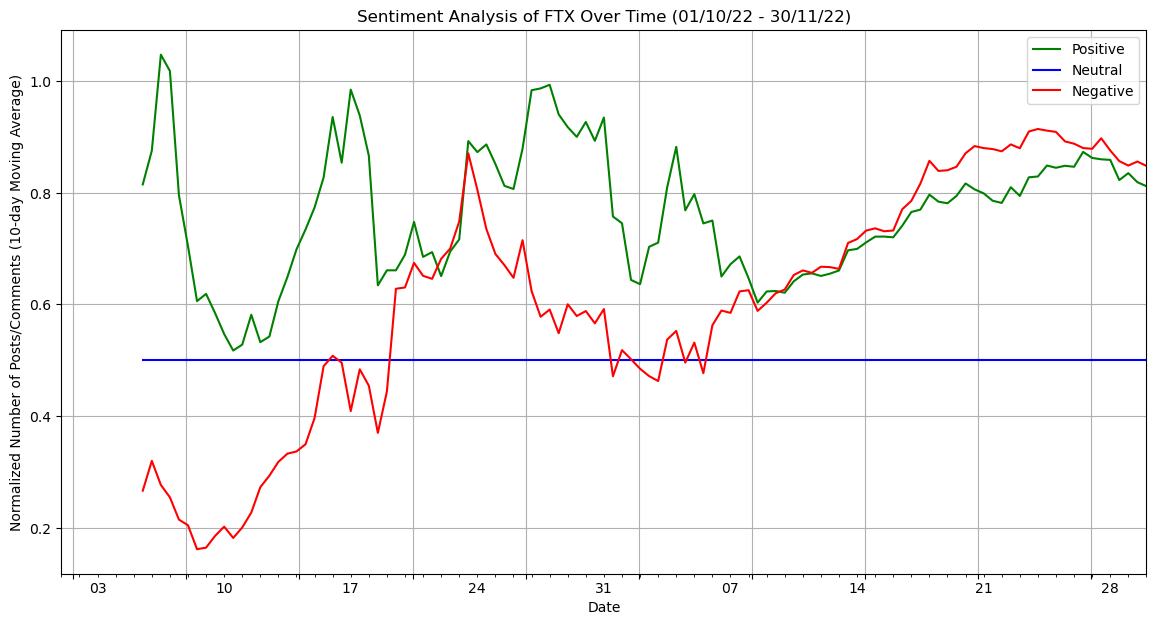

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/2.2
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/2.2

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (10-day Moving Average)')
ax.set_title('Sentiment Analysis of FTX Over Time (01/10/22 - 30/11/22)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


### Comparazione con il sentiment del mercato crypto in un periodo positivo (20/10/20 - 20/02/21)
Un'anailsi del sentiment in un periodo di forte positività nel sentiment di mercato (ad esempio bull run / ath / fomo) e confrontarlo con il grafico di FTX.

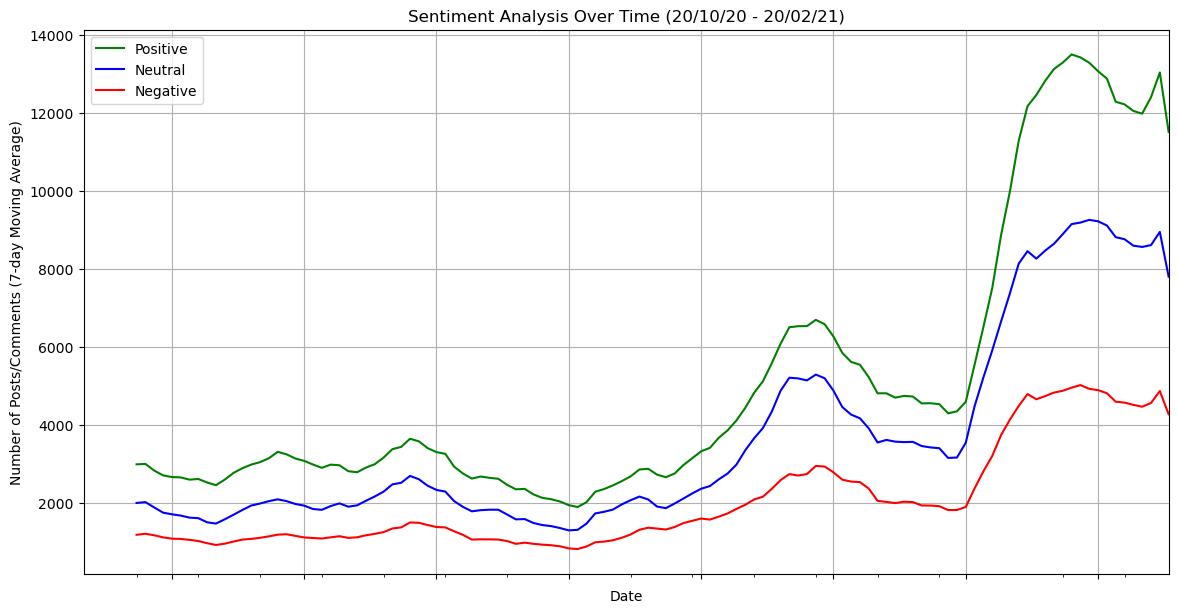

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati come grafico ad area
# pivot_df.plot.area(ax=ax, alpha=0.5)
# Plotta i dati
#pivot_df['positive'].plot.area(ax=ax, label='Positive', color='green')
#pivot_df['neutral'].plot.area(ax=ax, label='Neutral', color='blue')
#pivot_df['negative'].plot.area(ax=ax, label='Negative', color='red')

pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


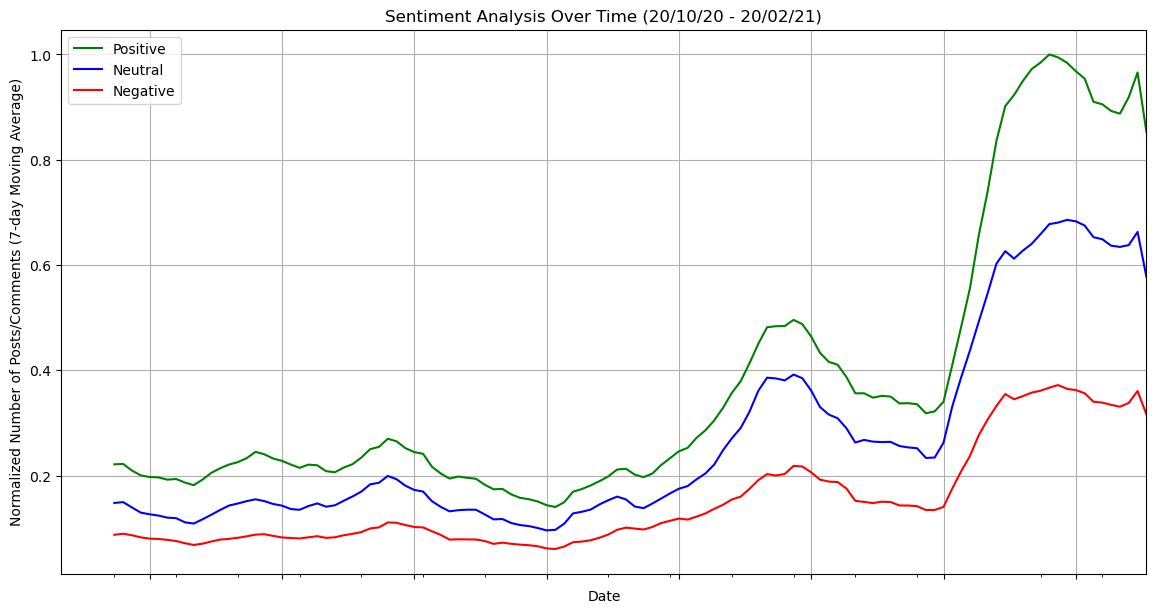

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['positive'].max()

# Normalizza tutte le linee usando il massimo valore della linea positiva
pivot_df['positive'] = pivot_df['positive'] / max_value
pivot_df['neutral'] = pivot_df['neutral'] / max_value
pivot_df['negative'] = pivot_df['negative'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


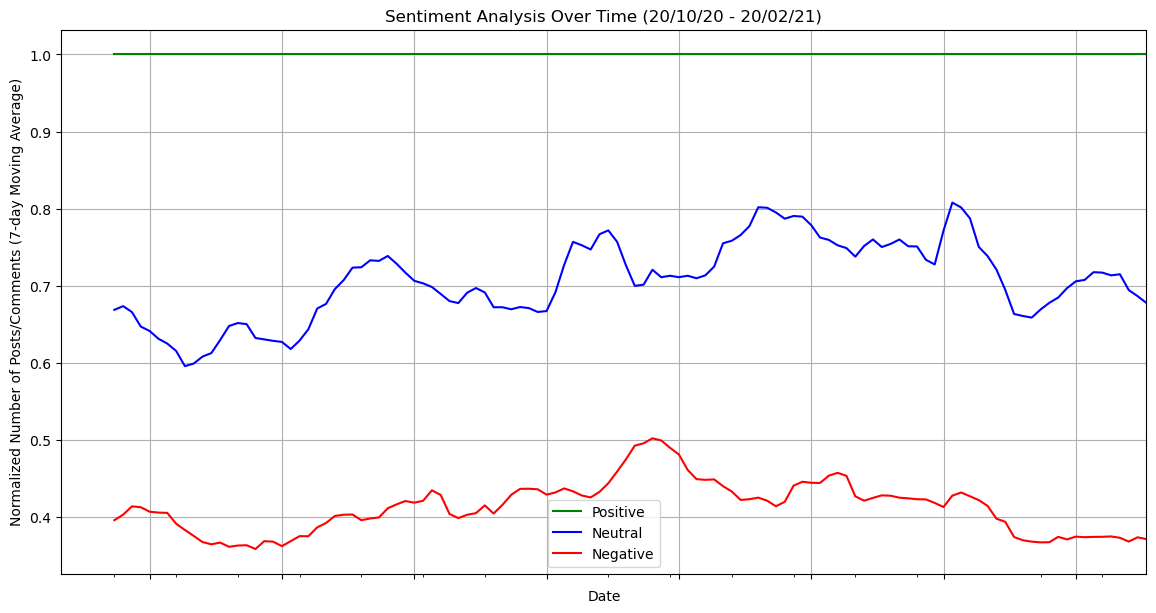

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['positive'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['neutral_normalized'] = pivot_df['neutral'] / pivot_df['positive']
pivot_df['negative_normalized'] = pivot_df['negative'] / pivot_df['positive']

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['positive_normalized'] = pivot_df['positive'] / pivot_df['positive']
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


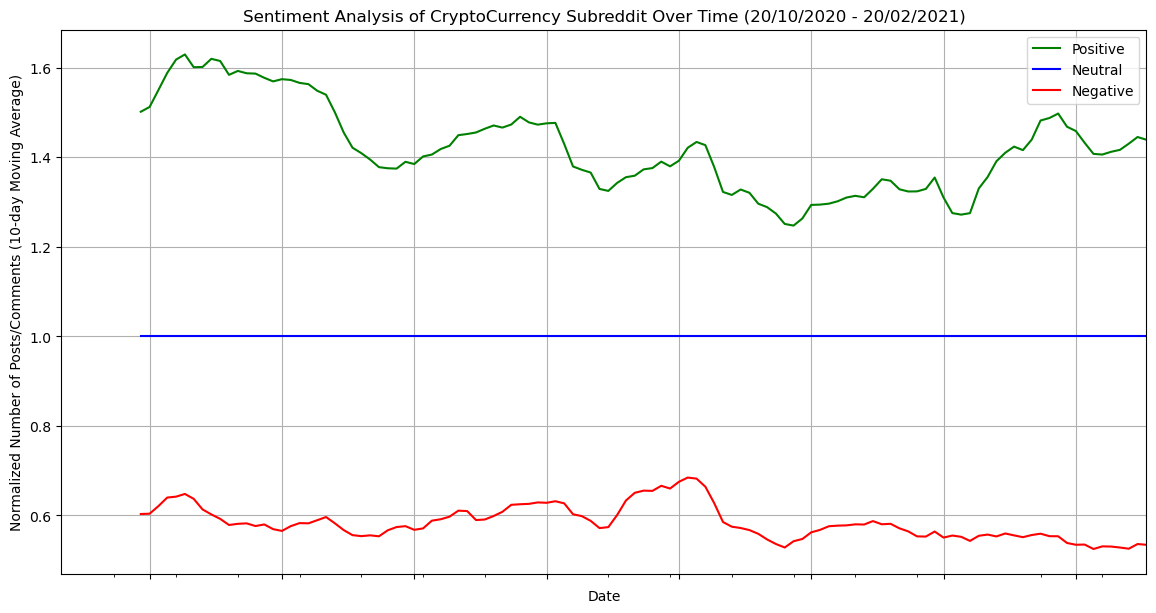

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])
#pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/1.635
#pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/1.635

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])
#pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (10-day Moving Average)')
ax.set_title('Sentiment Analysis of CryptoCurrency Subreddit Over Time (20/10/2020 - 20/02/2021)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


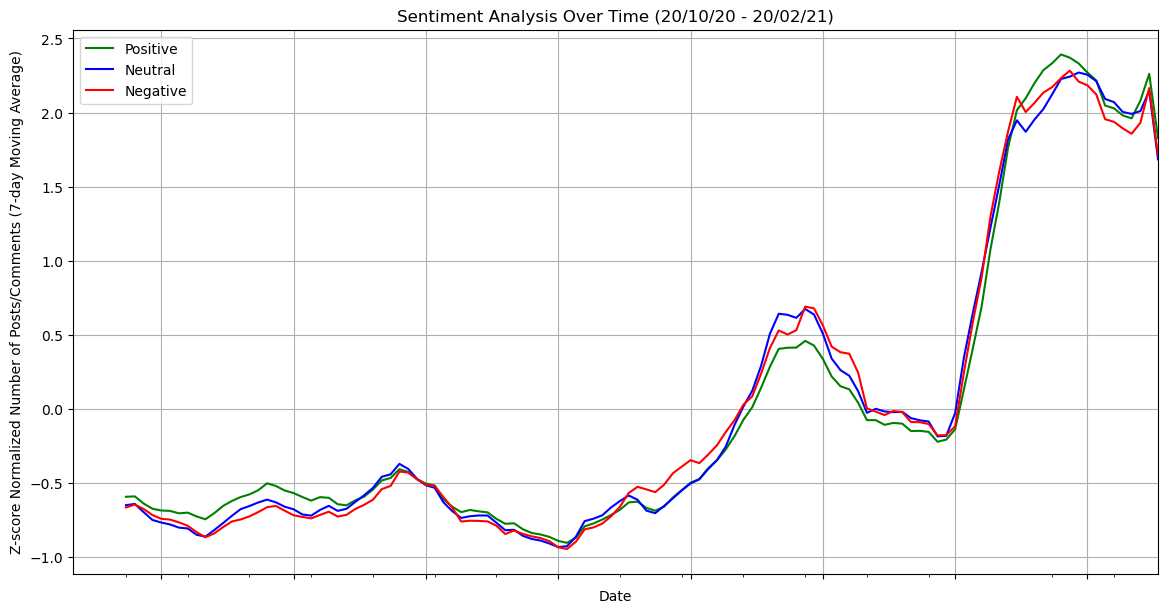

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola la media e la deviazione standard per ciascuna serie temporale
mean_positive = pivot_df['positive'].mean()
std_positive = pivot_df['positive'].std()

mean_neutral = pivot_df['neutral'].mean()
std_neutral = pivot_df['neutral'].std()

mean_negative = pivot_df['negative'].mean()
std_negative = pivot_df['negative'].std()

# Normalizza i dati usando il metodo z-score
#pivot_df['positive_normalized'] = (pivot_df['positive'] - mean_positive) / std_positive
#pivot_df['neutral_normalized'] = (pivot_df['neutral'] - mean_positive) / std_positive
#pivot_df['negative_normalized'] = (pivot_df['negative'] - mean_positive) / std_positive
pivot_df['positive_normalized'] = (pivot_df['positive'] - mean_positive) / std_positive
pivot_df['neutral_normalized'] = (pivot_df['neutral'] - mean_neutral) / std_neutral
pivot_df['negative_normalized'] = (pivot_df['negative'] - mean_negative) / std_negative

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Z-score Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


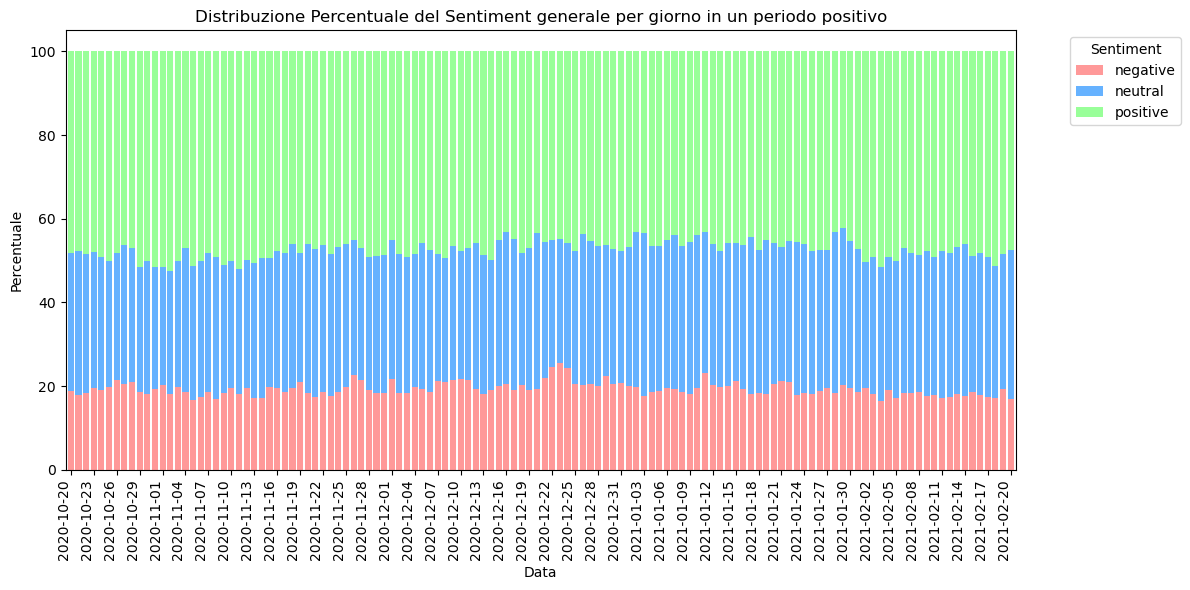

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
df = pd.read_csv(file_path)

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Specifica i colori desiderati
colors = ['#FF9999', '#66B2FF', '#99FF99']  # Rosso, Blu, Verde

# Creazione del barplot cumulato con colori personalizzati
ax = daily_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors, width=0.8)

# Mostra una data ogni 3
dates = daily_sentiment_percentages.index
ax.set_xticks(range(0, len(dates), 3))
ax.set_xticklabels([dates[i] for i in range(0, len(dates), 3)], rotation=90, ha='right')

plt.title('Distribuzione Percentuale del Sentiment generale per giorno in un periodo positivo')
plt.xlabel('Data')
plt.ylabel('Percentuale')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


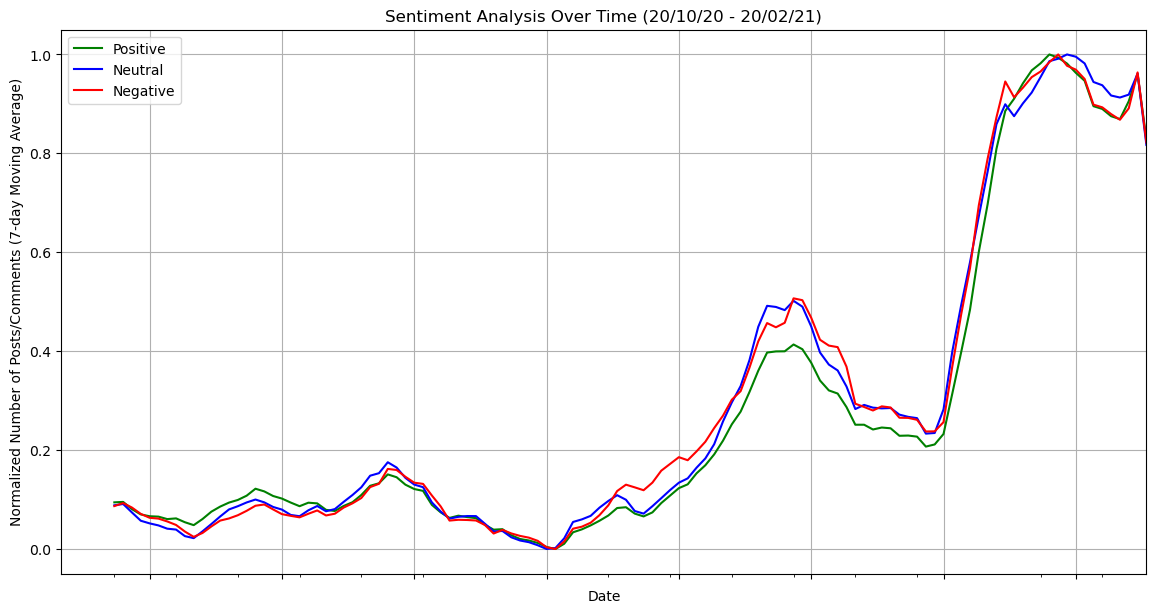

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Normalizza i dati
scaler = MinMaxScaler()
pivot_df[['positive', 'neutral', 'negative']] = scaler.fit_transform(pivot_df[['positive', 'neutral', 'negative']])

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


## Analisi del sentiment - SCORE

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_ftx2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_score_selftext'] = posts_df['selftext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
posts_df['sentiment_score_title'] = posts_df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment score
posts_df['sentiment_score'] = posts_df.apply(lambda row: row['sentiment_score_selftext'] if row['sentiment_score_selftext'] != 0 else row['sentiment_score_title'], axis=1)

# Creare il DataFrame con le colonne 'created_utc' e 'sentiment_score'
posts_sentiment_df = posts_df[['created_utc', 'sentiment_score']]

# Visualizzare il DataFrame risultante
print(posts_sentiment_df.head())

# Salva il DataFrame risultante
posts_sentiment_df.to_csv("sentiment_analysis_post_ftx_score.csv", index=False)


          created_utc  sentiment_score
0 2022-10-01 04:19:40           0.0000
1 2022-10-01 20:55:14          -0.5574
2 2022-10-02 22:26:45           0.9980
3 2022-10-03 09:20:01           0.0000
4 2022-10-03 15:51:24           0.2937


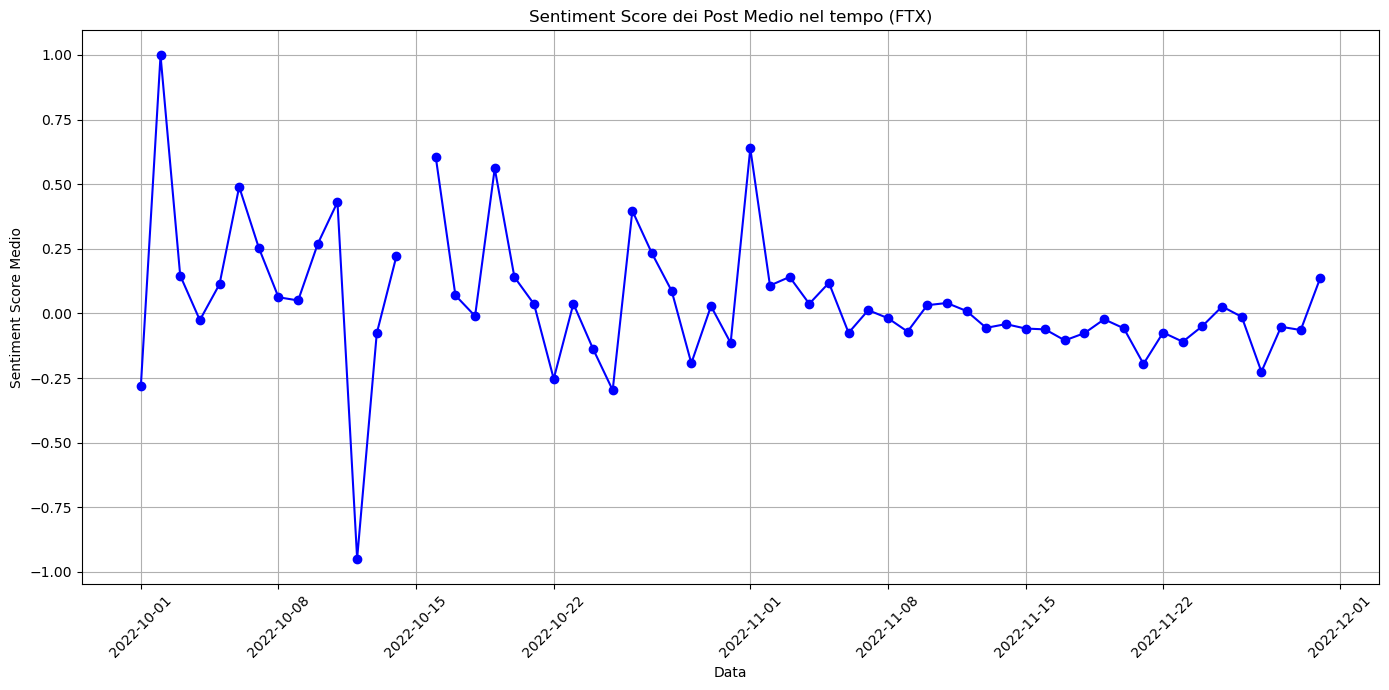

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il CSV
file_path = 'C:/Users/giaco/ProgettoIngInf/sentiment_analysis_post_ftx_score.csv'
df = pd.read_csv(file_path)

# Assicurati che 'created_utc' sia in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score dei Post Medio nel tempo (FTX)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il CSV
file_path = 'C:/Users/giaco/ProgettoIngInf/sentiment_analysis_post_ftx_score.csv'
df = pd.read_csv(file_path)

# Assicurati che 'created_utc' sia in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = df.set_index('created_utc').resample('D').mean()

In [3]:
df.set_index('created_utc').resample('D').mean()

sentiment_score
created_utc                 
2022-10-01         -0.278700
2022-10-02          0.998000
2022-10-03          0.146850
2022-10-04         -0.025800
2022-10-05          0.113150
...                      ...
2022-11-26         -0.013112
2022-11-27         -0.225454
2022-11-28         -0.051516
2022-11-29         -0.064125
2022-11-30          0.138900

[61 rows x 1 columns]

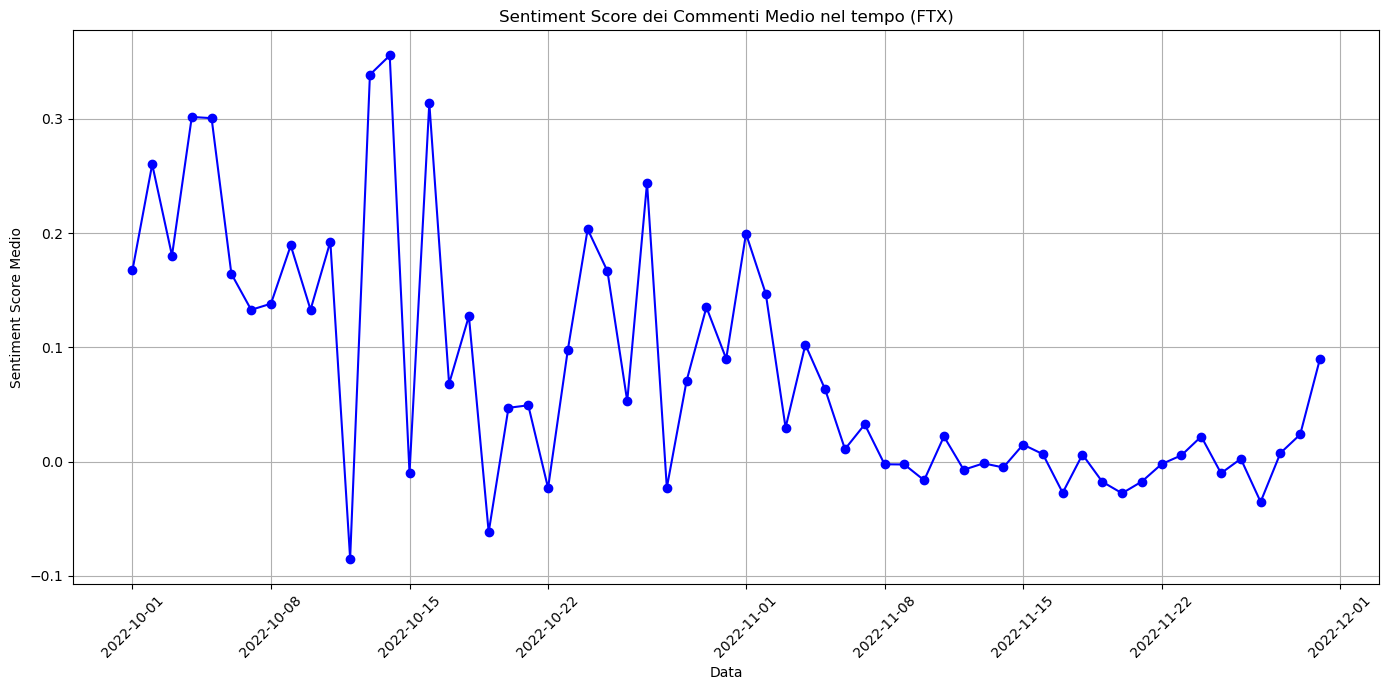

In [4]:
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_ftx2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment_score'] = comments_df['body'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Creare il DataFrame con le colonne 'created_utc' e 'sentiment_score'
comments_sentiment_df = comments_df[['created_utc', 'sentiment_score']]

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = comments_sentiment_df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score dei Commenti Medio nel tempo (FTX)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Salva il DataFrame risultante
comments_sentiment_df.to_csv("sentiment_analysis_comments_ftx_score.csv", index=False)


# Predizione prezzo

Per fare una predizione utilizzando Random Forest Regression di scikit-learn e normalizzare le feature, segui questi passaggi:

### 1. Preparare i Dati
Hai bisogno di un DataFrame con i giorni come indici e le diverse feature come colonne. Le feature possono includere il prezzo della crypto, volume di scambio, ecc.

### 2. Normalizzare le Feature
La normalizzazione può essere fatta dividendo ogni valore per il massimo valore della rispettiva colonna.

### 3. Random Forest Regression
Utilizzeremo `RandomForestRegressor` di scikit-learn per creare e addestrare il modello.

### Esempio

Supponiamo di avere un DataFrame con i dati di due crypto (crypto1 e crypto2). I passaggi dettagliati sono:

#### 1. Importare le librerie necessarie
```python
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
```

#### 2. Creare un DataFrame di esempio
```python
# Creare un esempio di DataFrame con dati fittizi
data = {
    'day': pd.date_range(start='2022-01-01', periods=10, freq='D'),
    'crypto1_price': np.random.rand(10) * 1000,
    'crypto1_volume': np.random.rand(10) * 10000,
    'crypto2_price': np.random.rand(10) * 500,
    'crypto2_volume': np.random.rand(10) * 7000
}
df = pd.DataFrame(data)
df.set_index('day', inplace=True)
```

#### 3. Normalizzare le Feature
```python
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
```

#### 4. Preparare i dati per il modello
```python
# Feature e target (supponiamo di voler predire il prezzo di crypto1)
X = df_normalized.drop(columns='crypto1_price')
y = df_normalized['crypto1_price']

# Suddividere i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

#### 5. Addestrare il Modello
```python
# Creare il modello
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Addestrare il modello
model.fit(X_train, y_train)
```

#### 6. Fare Predizioni e Valutare il Modello
```python
# Fare predizioni sul test set
y_pred = model.predict(X_test)

# Valutare il modello
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
```

### Spiegazione dei Passaggi

1. **Importare le librerie**: `pandas` per la gestione dei dati, `numpy` per operazioni numeriche, `train_test_split` per dividere i dati, `MinMaxScaler` per la normalizzazione, `RandomForestRegressor` per il modello e `mean_squared_error` per la valutazione.

2. **Creare un DataFrame**: Qui creiamo un DataFrame fittizio con i prezzi e volumi di due crypto.

3. **Normalizzazione**: Usiamo `MinMaxScaler` per normalizzare i dati. Questo trasforma ogni feature in modo che i valori siano tra 0 e 1.

4. **Preparare i dati**: Dividiamo il DataFrame normalizzato in feature (`X`) e target (`y`). Il target è ciò che vogliamo predire, in questo caso il prezzo di `crypto1`. Suddividiamo poi i dati in training e test set.

5. **Addestrare il Modello**: Usiamo `RandomForestRegressor` per addestrare il modello sui dati di training.

6. **Fare Predizioni e Valutare**: Facciamo predizioni sui dati di test e valutiamo il modello usando l'errore quadratico medio (MSE).

Con questo approccio, puoi normalizzare le tue feature e utilizzare un modello di regressione random forest per fare predizioni sui prezzi delle criptovalute. Se hai domande o necessiti di ulteriori dettagli, fammelo sapere!

## Preparo i dati

### Preparo il csv del **numero di post**

In [124]:
import pandas as pd

# Carica il file CSV
numero_post_df = pd.read_csv('numeroPostFtx.csv')
numero_post_df['date'] = pd.to_datetime(numero_post_df['created_utc']).dt.tz_localize(None)

# Stampa le colonne presenti nel DataFrame
print("Colonne presenti nel DataFrame:", numero_post_df.columns.tolist())

Colonne presenti nel DataFrame: ['created_utc', 'subreddit', 'score', 'selftext', 'permalink', 'author', 'num_comments', 'edited', 'stickied', 'link_flair_text', 'title', 'distinguished', 'id', 'downs', 'ups', 'date']


In [125]:
# Elenco delle colonne da eliminare
columns_to_drop = [
    'created_utc', 'selftext', 'subreddit', 'permalink', 'author', 'edited', 'stickied', 'link_flair_text',
    'title', 'distinguished', 'id', 'downs', 'ups'
]
# Colonne presenti nel DataFrame: ['date', 'score', 'num_comments']

# Elimina le colonne specificate
numero_post_df.drop(columns=columns_to_drop, inplace=True)

# Salva il dataframe modificato in un nuovo file CSV
output_path = 'numeroPostFtx_1.csv'
numero_post_df.to_csv(output_path, index=False)

print(f"Cleaned data saved to '{output_path}'")


Cleaned data saved to 'numeroPostFtx_1.csv'


In [138]:
# Carica il file CSV
file_path = 'numeroPostFtx_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Trasforma le date per rimuovere l'ora
df['date'] = df['date'].dt.date

# Aggrega le righe con la stessa data
aggregated_df = df.groupby('date').agg(
    score_mean=('score', 'mean'),
    num_comments_mean=('num_comments', 'mean'),
    num_post=('score', 'size')  # Conta il numero di righe per ogni data
).reset_index()

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in aggregated_df.columns if col != 'date']
aggregated_df = aggregated_df[cols]

# Salva il dataframe aggregato in un nuovo file CSV
output_path = 'numeroPostFtx_2.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated data saved to '{output_path}'")

Aggregated data saved to 'numeroPostFtx_2.csv'


In [139]:
# Normalizza le colonne score_mean e num_comments_mean e num_post
aggregated_df['score_mean'] = aggregated_df['score_mean'] / aggregated_df['score_mean'].max()
aggregated_df['num_comments_mean'] = aggregated_df['num_comments_mean'] / aggregated_df['num_comments_mean'].max()
aggregated_df['num_post'] = aggregated_df['num_post'] / aggregated_df['num_post'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'numeroPostFtx_3.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'numeroPostFtx_3.csv'


Sono pronti nel file **numeroPostFtx_3.csv**

### Preparo il csv del **numero di commenti**

In [127]:
import pandas as pd

numero_comm_df = pd.read_csv('numeroCommFtx.csv')
numero_comm_df['date'] = pd.to_datetime(numero_comm_df['created_utc']).dt.tz_localize(None)

# Stampa le colonne presenti nel DataFrame
print("Colonne presenti nel DataFrame:", numero_comm_df.columns.tolist())

Colonne presenti nel DataFrame: ['created_utc', 'author', 'body', 'score', 'controversiality', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'link_id', 'parent_id', 'date']


In [128]:
# Elenco delle colonne da eliminare
columns_to_drop = [
    'created_utc', 'author', 'body', 'controversiality', 'subreddit', 'author_flair_text', 'author_premium',
    'gilded', 'link_id', 'parent_id'
]
# Colonne presenti nel DataFrame: ['date', 'score']

# Elimina le colonne specificate
numero_comm_df.drop(columns=columns_to_drop, inplace=True)

# Salva il dataframe modificato in un nuovo file CSV
output_path = 'numeroCommFtx_1.csv'
numero_comm_df.to_csv(output_path, index=False)

print(f"Cleaned data saved to '{output_path}'")

Cleaned data saved to 'numeroCommFtx_1.csv'


In [133]:
# Carica il file CSV
file_path = 'numeroCommFtx_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Trasforma le date per rimuovere l'ora
df['date'] = df['date'].dt.date

# Aggrega le righe con la stessa data
aggregated_df = df.groupby('date').agg(
    comm_score_mean=('score', 'mean'),
    num_comm=('score', 'size')  # Conta il numero di righe per ogni data
).reset_index()

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in aggregated_df.columns if col != 'date']
aggregated_df = aggregated_df[cols]

# Salva il dataframe aggregato in un nuovo file CSV
output_path = 'numeroCommFtx_2.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated data saved to '{output_path}'")

Aggregated data saved to 'numeroCommFtx_2.csv'


In [135]:
# Normalizza le colonne comm_score_mean e num_comments_mean
aggregated_df['comm_score_mean'] = aggregated_df['comm_score_mean'] / aggregated_df['comm_score_mean'].max()
aggregated_df['num_comm'] = aggregated_df['num_comm'] / aggregated_df['num_comm'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'numeroCommFtx_3.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'numeroCommFtx_3.csv'


Sono pronti nel file **numeroCommFtx_3.csv**

### Preparo il csv di **Google Trends**
Sono pronti nel file **trendsFtx_2.csv**

### Preparo il csv di **media e deviazione standard dei commenti**

In [145]:
# date,mean_comments_24h,var_comments_24h,std_comments_24h,upper_std,lower_std
# Carica il file CSV
file_path = 'mediaDeviazioneComm_ftx_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Normalizza le colonne score_mean e num_comments_mean e num_post
df['mean_comments_24h'] = df['mean_comments_24h'] / df['mean_comments_24h'].max()
df['var_comments_24h'] = df['var_comments_24h'] / df['var_comments_24h'].max()
df['std_comments_24h'] = df['std_comments_24h'] / df['std_comments_24h'].max()
df['upper_std'] = df['upper_std'] / df['upper_std'].max()
#df['lower_std'] = (-1)*(df['lower_std'] / df['lower_std'].min())
df['lower_std'] = (df['lower_std'] / df['lower_std'].min())

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'mediaDeviazioneComm_ftx_2.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'mediaDeviazioneComm_ftx_2.csv'


Sono pronti nel file **mediaDeviazioneComm_ftx_2.csv**

### Preparo il csv della **percentuale delle tipologie di sentiment su base giornaliera**

In [147]:
# date,negative,neutral,positive
# Carica il file CSV
file_path = 'sentimentPercentagesFtx.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Normalizza le colonne score_mean e num_comments_mean e num_post
df['negative'] = df['negative'] / df['negative'].max()
df['neutral'] = df['neutral'] / df['neutral'].max()
df['positive'] = df['positive'] / df['positive'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'sentimentPercentagesFtx_1.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'sentimentPercentagesFtx_1.csv'


(ho eliminato le date prima di novembre e quelle dopo al 20 novembre)

Sono pronti nel file **sentimentPercentagesFtx_2.csv**

### Preparo il csv del **prezzo di FTT**

In [153]:
import pandas as pd
from datetime import datetime

# Carica il file CSV
file_path = 'FTTUSDT_1d_nov.csv'
df = pd.read_csv(file_path)

# open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore

# Assicurati che la colonna della data sia in formato datetime, interpretando correttamente i nanosecondi
df['date'] = pd.to_datetime(df['open_time'], unit='ms').dt.date


# Elenco delle colonne da eliminare
columns_to_drop = [
    'open_time', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
    'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
]
# Colonne presenti nel DataFrame: ['date', 'open']

# Elimina le colonne specificate
df.drop(columns=columns_to_drop, inplace=True)

# Rinominare la colonna
df.rename(columns={'open': 'price_ftx'}, inplace=True)

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in df.columns if col != 'date']
df = df[cols]

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'FTTUSDT_1d_nov_2.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'FTTUSDT_1d_nov_2.csv'


## Unisco i vari data frame

In [156]:
import pandas as pd
import glob

# Percorso ai file CSV
file_paths = glob.glob('csvFtx/*.csv')  # Assicurati che i tuoi CSV siano nella stessa directory dello script

# Lista per memorizzare i dataframe
dataframes = []

# Carica ogni file CSV e aggiungilo alla lista
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Unisci tutti i dataframe sulla colonna 'date'
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.merge(df, on='date', how='outer')

# Salva il dataframe combinato in un nuovo file CSV
output_path = 'csvFtx/combined_data_ftx.csv'
combined_df.to_csv(output_path, index=False)

print(f"Combined data saved to '{output_path}'")

Combined data saved to 'csvFtx/combined_data_ftx.csv'


In [159]:
# Carica il file CSV
file_path = 'csvFtx/combined_data_ftx.csv'
df = pd.read_csv(file_path)

# Porta la colonna price_ftx come ultima colonna
cols = [col for col in df.columns if col != 'price_ftx'] + ['price_ftx']
df = df[cols]

# Salva il dataframe combinato in un nuovo file CSV
output_path = 'csvFtx/combined_data_ftx_1.csv'
df.to_csv(output_path, index=False)

print(f"Combined data saved to '{output_path}'")

Combined data saved to 'csvFtx/combined_data_ftx_1.csv'


## Creare il modello, addestrarlo e fare predizioni

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Carica il file CSV
file_path = 'csvFtx/combined_data_ftx_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Seleziona le colonne di interesse per il modello
# Supponiamo che il target sia la colonna 'price_ftx'
# E tutte le altre colonne tranne 'date' siano feature
features_normalized = df.drop(columns=['date', 'price_ftx'])
target = df['price_ftx']

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)

# Creare il modello
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Addestrare il modello
model.fit(X_train, y_train)

# Fare predizioni sul test set
y_pred = model.predict(X_test)

# Valutare il modello
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

# Fare predizioni sull'intero intervallo di date usato per l'addestramento
y_all_pred = model.predict(features_normalized)

# Aggiungi le predizioni al DataFrame originale
df['price_ftx_pred'] = y_all_pred

# Salva il dataframe con le predizioni in un nuovo file CSV
output_path = 'combined_data_ftx_with_predictions.csv'
df.to_csv(output_path, index=False)

print(f"Data with predictions saved to '{output_path}'")


Mean Squared Error: 15.55796913863171
R^2: 0.8944551334809964
Data with predictions saved to 'combined_data_ftx_with_predictions.csv'


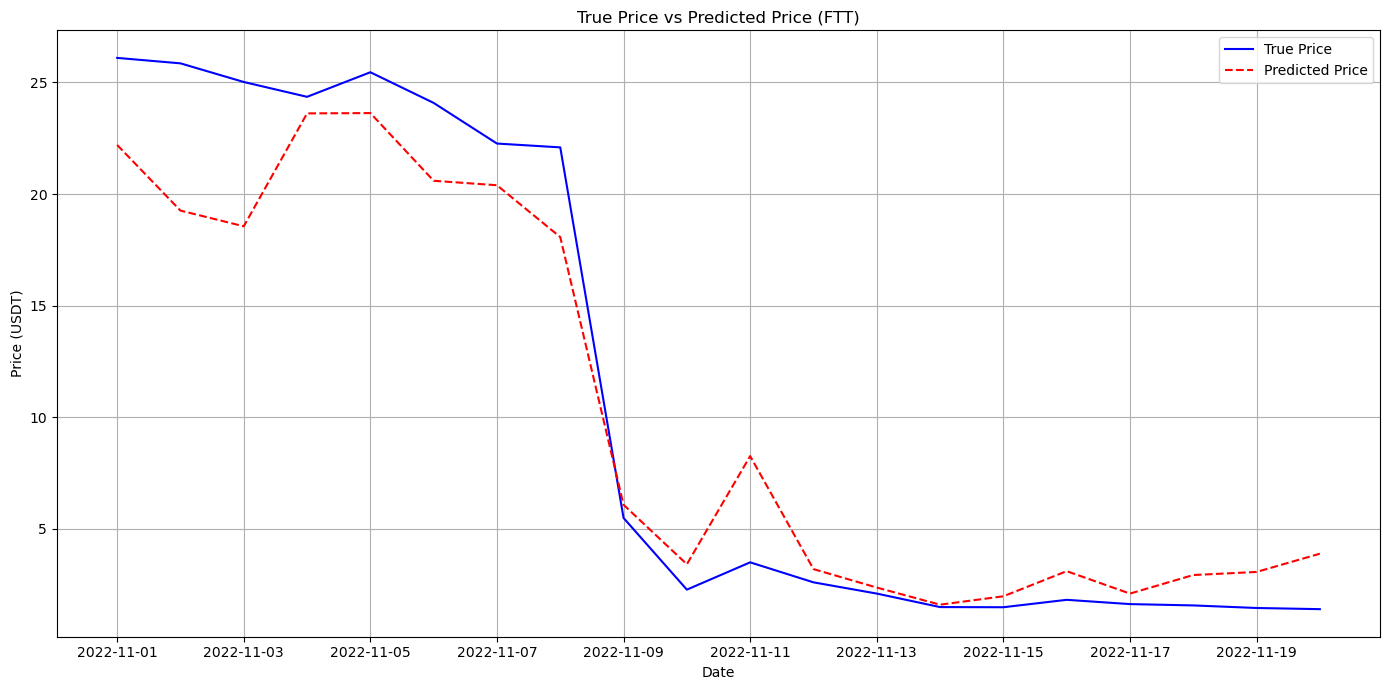

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV con le predizioni
file_path = 'combined_data_ftx_with_predictions.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Plotta i grafici del prezzo vero e di quello predetto
plt.figure(figsize=(14, 7))

plt.plot(df['date'], df['price_ftx'], label='True Price', color='blue')
plt.plot(df['date'], df['price_ftx_pred'], label='Predicted Price', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.title('True Price vs Predicted Price (FTT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()